<a href="https://colab.research.google.com/github/RodrigoCharalla/proyecto-titanic/blob/main/ml_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalación y llamado de paquetes

In [1]:
 install.packages(c("tidyverse", "caret","ggpubr",
                  "titanic","randomForest","doMC","recipes"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘future’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘future.apply’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘diagram’, ‘lava’, ‘Rcpp’, ‘car’, ‘prodlim’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘reshape2’, ‘ggrepel’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’




In [2]:
#install.packages("caret")

In [3]:
#install.packages("ggpubr")

In [4]:
#install.packages("tidyverse")

In [5]:
#install.packages("titanic")

In [6]:
#install.packages("randomForest")

In [7]:
#install.packages("doMC")

In [8]:
#install.packages("recipes")

In [9]:
packages <- c("tidyverse", "caret", "ggpubr", "titanic", "randomForest", "doMC", "recipes")
lapply(packages, library, character.only = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: foreach


Attaching package: ‘for

[[1]]
 [1] "lubridate" "forcats"   "stringr"   "dplyr"     "purrr"     "readr"    
 [7] "tidyr"     "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics" 
[13] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "caret"     "lattice"   "lubridate" "forcats"   "stringr"   "dplyr"    
 [7] "purrr"     "readr"     "tidyr"     "tibble"    "ggplot2"   "tidyverse"
[13] "stats"     "graphics"  "grDevices" "utils"     "datasets"  "methods"  
[19] "base"     

[[3]]
 [1] "ggpubr"    "caret"     "lattice"   "lubridate" "forcats"   "stringr"  
 [7] "dplyr"     "purrr"     "readr"     "tidyr"     "tibble"    "ggplot2"  
[13] "tidyverse" "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[19] "methods"   "base"     

[[4]]
 [1] "titanic"   "ggpubr"    "caret"     "lattice"   "lubridate" "forcats"  
 [7] "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"     "tibble"   
[13] "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices" "utils"    
[19] "datasets"  "methods"   "base"     

[[5]]
 [1] "randomForest" "titanic"      "ggpubr"       "caret"        "lattice"     
 [6] "lubridate"    "forcats"      "stringr"      "dplyr"        "purrr"       
[11] "readr"        "tidyr"        "tibble"       "ggplot2"      "tidyverse"   
[16] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[21] "methods"      "base"        

[[6]]
 [1] "doMC"         "parallel"     "iterators"    "foreach"      "randomForest"
 [6] "titanic"      "ggpubr"       "caret"        "lattice"      "lubridate"   
[11] "forcats"      "stringr"      "dplyr"        "purrr"        "readr"       
[16] "tidyr"        "tibble"       "ggplot2"      "tidyverse"    "stats"       
[21] "graphics"     "grDevices"    "utils"        "datasets"     "methods"     
[26] "base"        

[[7]]
 [1] "recipes"      "doMC"         "parallel"     "iterators"    "foreach"     
 [6] "randomForest" "titanic"      "ggpubr"       "caret"        "lattice"     
[11] "lubridate"    "forcats"      "stringr"      "dplyr"        "purrr"       
[16] "readr"        "tidyr"        "tibble"       "ggplot2"      "tidyverse"   
[21] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[26] "methods"      "base"

In [10]:
library(caret)

#Dataset Titanic

In [11]:
library(tidyverse)
library(titanic)
datos <- titanic_train

#Análisis exploratorio de los datos




* **PassengerId:** identificador único del pasajero.

* **Survived:** si el pasajero sobrevivió al naufragio, codificada como 0 (no) y 1 (si). Esta es la variable respuesta que interesa predecir.

* **Pclass:** clase a la que pertenecía el pasajero: 1, 2 o 3.

* **Name:** nombre del pasajero.

* **Sex:** sexo del pasajero.

* **Age:** edad del pasajero.

* **SibSp:** número de hermanos, hermanas, hermanastros o hermanastras en el barco.

* **Parch:** número de padres e hijos en el barco.

* **Ticket:** identificador del billete.

* **Fare:** precio pagado por el billete.

* **Cabin:** identificador del camarote asignado al pasajero.

* **Embarked:** puerto en el que embarcó el pasajero.

## Tipo de variables


In [12]:
# Resumen del set de datos
glimpse(datos)

Rows: 891
Columns: 12
$ PassengerId <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…
$ Survived    <int> 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1…
$ Pclass      <int> 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3…
$ Name        <chr> "Braund, Mr. Owen Harris", "Cumings, Mrs. John Bradley (Fl…
$ Sex         <chr> "male", "female", "female", "female", "male", "male", "mal…
$ Age         <dbl> 22, 38, 26, 35, 35, NA, 54, 2, 27, 14, 4, 58, 20, 39, 14, …
$ SibSp       <int> 1, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 1, 0, 0, 4, 0, 1, 0…
$ Parch       <int> 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 5, 0, 0, 1, 0, 0, 0…
$ Ticket      <chr> "A/5 21171", "PC 17599", "STON/O2. 3101282", "113803", "37…
$ Fare        <dbl> 7.2500, 71.2833, 7.9250, 53.1000, 8.0500, 8.4583, 51.8625,…
$ Cabin       <chr> "", "C85", "", "C123", "", "", "E46", "", "", "", "G6", "C…
$ Embarked    <chr> "S", "C", "S", "S", "S", "Q", "S", "S", "S", "C", "S", "S"…


In [13]:
datos$Survived <- if_else(datos$Survived == 1, "Si", "No")
datos$Survived <- as.factor(datos$Survived)

In [14]:
datos$Pclass <- as.factor(datos$Pclass)

In [15]:
datos$SibSp <- as.factor(datos$SibSp)
datos$Parch <- as.factor(datos$Parch)

In [16]:
datos$Sex      <- as.factor(datos$Sex)
datos$Embarked <- as.factor(datos$Embarked)

In [17]:
datos_long <- datos %>% gather(key = "variable", value = "valor", -PassengerId)
head(datos_long)

Warning message:
“attributes are not identical across measure variables; they will be dropped”


,PassengerId,variable,valor
,<int>,<chr>,<chr>
1,1,Survived,No
2,2,Survived,Si
3,3,Survived,Si
4,4,Survived,Si
5,5,Survived,No
6,6,Survived,No


## Número de observaciones y valores ausentes

In [18]:
# Número de observaciones del set de datos
nrow(datos)

[1] 891

In [19]:
# Detección si hay alguna fila incompleta
any(!complete.cases(datos))

[1] TRUE

In [20]:
# Número de datos ausentes por variable
map_dbl(datos, .f = function(x){sum(is.na(x))})

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0           0           0

In [21]:
datos %>% map_lgl(.f = function(x){any(!is.na(x) & x == "")})

PassengerId    Survived      Pclass        Name         Sex         Age 
      FALSE       FALSE       FALSE       FALSE       FALSE       FALSE 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
      FALSE       FALSE       FALSE       FALSE        TRUE        TRUE

In [22]:
# La variable Cabin está almacenada como character
datos$Cabin[datos$Cabin == ""] <- NA

In [23]:
levels(datos$Embarked)

[1] ""  "C" "Q" "S"

In [24]:
datos$Embarked <- as.character(datos$Embarked)
datos$Embarked[datos$Embarked == ""] <- NA
datos$Embarked <- as.factor(datos$Embarked)
levels(datos$Embarked)

[1] "C" "Q" "S"

In [25]:
# Este cambio también se aplica al dataframe datos_long
datos_long$valor[datos_long$valor == ""] <- NA

In [26]:
# Número de datos ausentes por variable
map_dbl(datos, .f = function(x){sum(is.na(x))})

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0         687           2

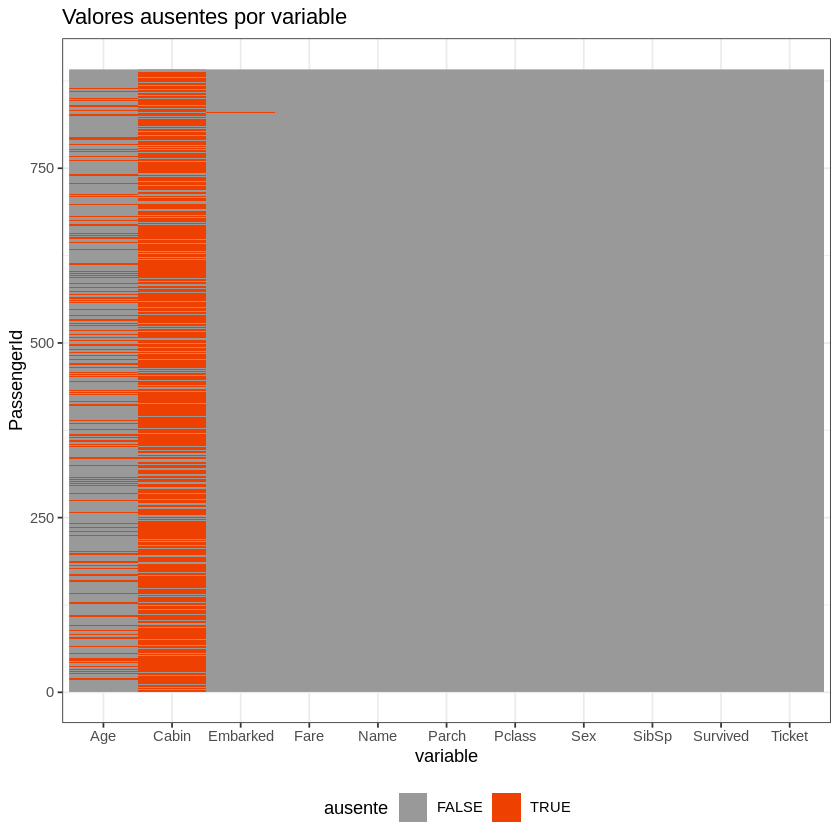

In [27]:
# Representación gráfica de los datos ausentes
datos_long <- datos_long %>%  mutate(ausente = is.na(valor))
ggplot(data = datos_long, aes(x = variable,
                              y = PassengerId,
                              fill = ausente)) +
  geom_raster() +
  scale_fill_manual(values = c("gray60", "orangered2")) +
  theme_bw() +
  labs(title = "Valores ausentes por variable") +
  theme(legend.position = "bottom")

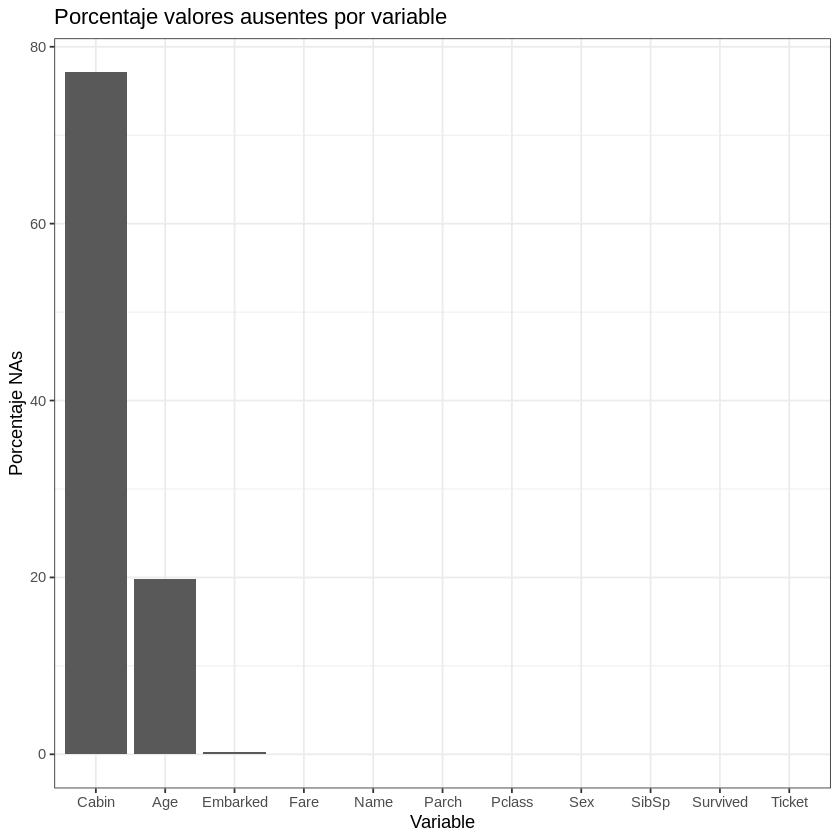

In [28]:
datos_long %>%
  group_by(variable) %>%
  summarize(porcentaje_NA = 100 * sum(is.na(valor)) / length(valor)) %>%
  ggplot(aes(x = reorder(variable, desc(porcentaje_NA)), y = porcentaje_NA)) +
    geom_col() +
    labs(title = "Porcentaje valores ausentes por variable",
         x = "Variable", y = "Porcentaje NAs") +
    theme_bw()

## Distribución de variables respuesta

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


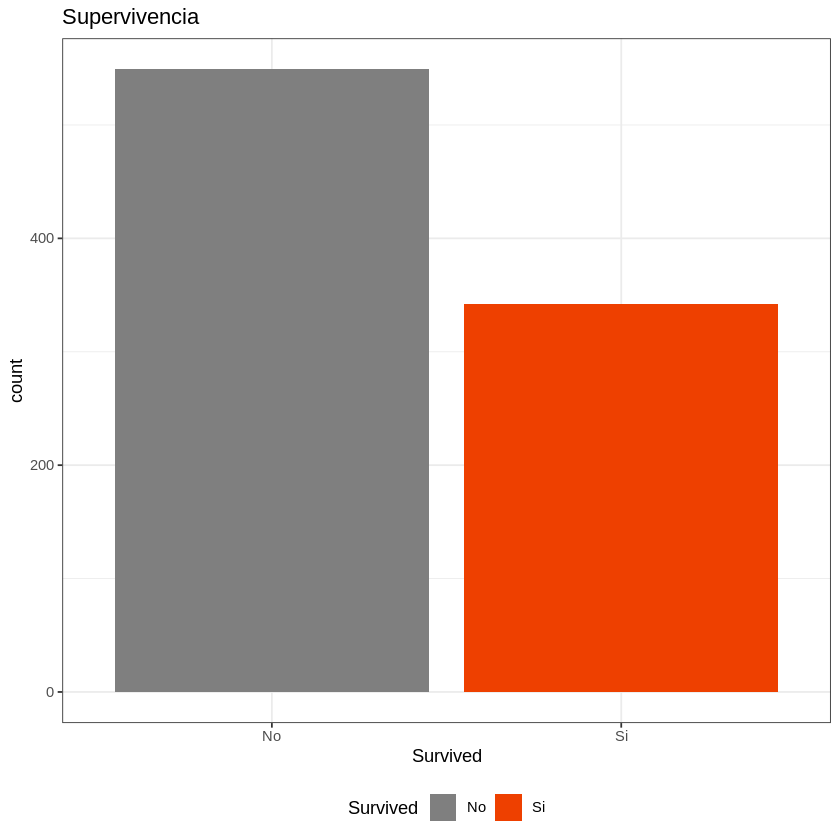

In [29]:
ggplot(data = datos, aes(x = Survived, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Supervivencia") +
  theme_bw() +
  theme(legend.position = "bottom")

In [30]:
# Tabla de frecuencias
table(datos$Survived)


 No  Si 
549 342 

In [31]:
prop.table(table(datos$Survived)) %>% round(digits = 2)


  No   Si 
0.62 0.38 

In [32]:
# Porcentaje de aciertos si se predice para todas las observaciones que
#no sobrevivieron.
n_observaciones <- nrow(datos)
predicciones <- rep(x = "No",  n_observaciones)
mean(predicciones == datos$Survived) * 100

[1] 61.61616

## Distribución de variables continuas

Warning message:
“Removed 177 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 177 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 177 rows containing missing values (`geom_point()`).”


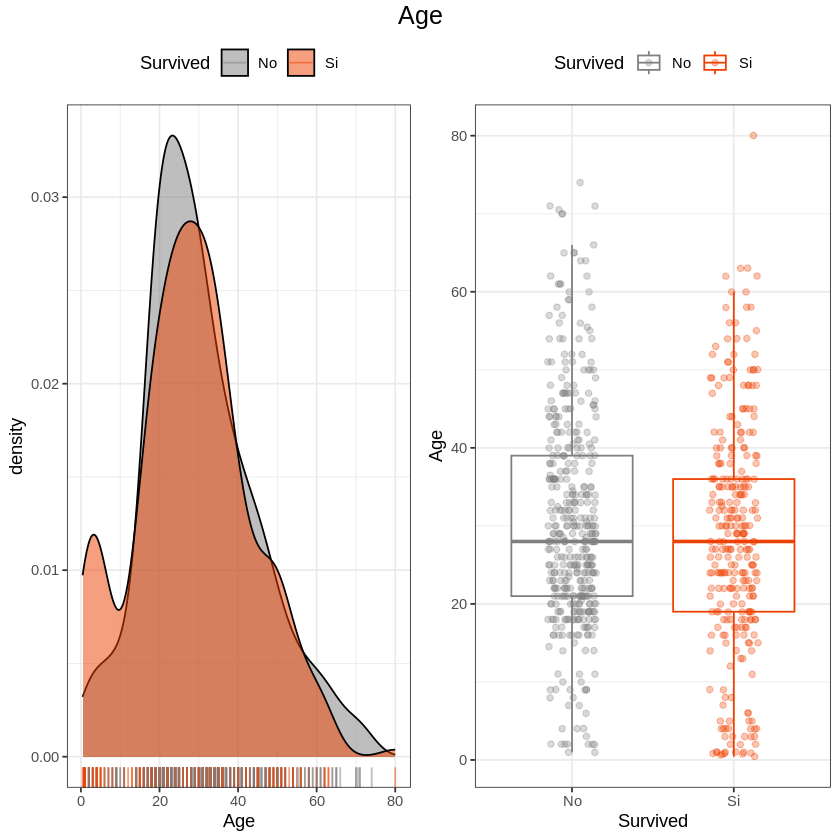

In [33]:
library(ggpubr)
p1 <- ggplot(data = datos, aes(x = Age, fill = Survived)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2")) +
      geom_rug(aes(color = Survived), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
p2 <- ggplot(data = datos, aes(x = Survived, y = Age, color = Survived)) +
      geom_boxplot(outlier.shape = NA) +
      geom_jitter(alpha = 0.3, width = 0.15) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
final_plot <- ggarrange(p1, p2, legend = "top")
final_plot <- annotate_figure(final_plot, top = text_grob("Age", size = 15))
final_plot

In [34]:
# Estadísticos de la edad de los supervivientes y fallecidos
datos %>% filter(!is.na(Age)) %>% group_by(Survived) %>%
          summarise(media = mean(Age),
                    mediana = median(Age),
                    min = min(Age),
                    max = max(Age))

Survived,media,mediana,min,max
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
No,30.62618,28,1.00,74
Si,28.34369,28,0.42,80


In [35]:
datos <- datos %>%
         mutate(Age_grupo = case_when(Age <= 10  ~ "niño",
                                      Age > 10 & Age <= 60  ~ "adulto",
                                      Age > 60 ~ "anciano"))
datos$Age_grupo <- as.factor(datos$Age_grupo)

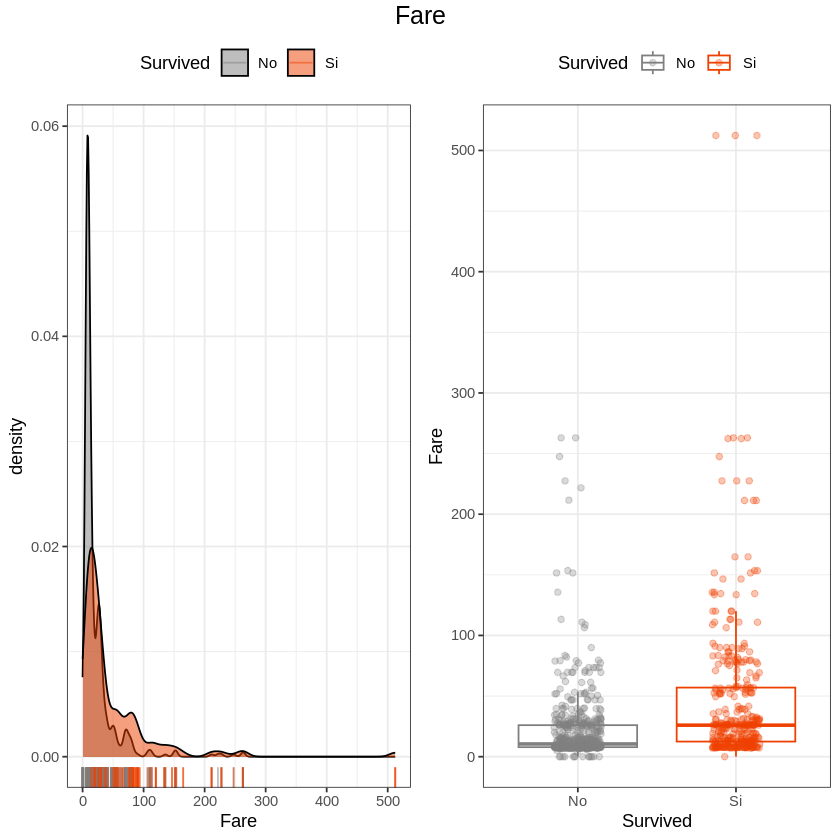

In [36]:
p1 <- ggplot(data = datos, aes(x = Fare, fill = Survived)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2")) +
      geom_rug(aes(color = Survived), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
p2 <- ggplot(data = datos, aes(x = Survived, y = Fare, color = Survived)) +
      geom_boxplot(outlier.shape = NA) +
      geom_jitter(alpha = 0.3, width = 0.15) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
final_plot <- ggarrange(p1, p2, legend = "top")
final_plot <- annotate_figure(final_plot, top = text_grob("Fare", size = 15))
final_plot

In [37]:
# Estadísticos del precio del billete de los supervivientes y fallecidos
datos %>% filter(!is.na(Fare)) %>% group_by(Survived) %>%
          summarise(media = mean(Fare),
                    mediana = median(Fare),
                    min = min(Fare),
                    max = max(Fare))

Survived,media,mediana,min,max
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
No,22.11789,10.5,0,263.0000
Si,48.39541,26.0,0,512.3292


Warning message:
“Removed 15 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 15 rows containing non-finite values (`stat_boxplot()`).”


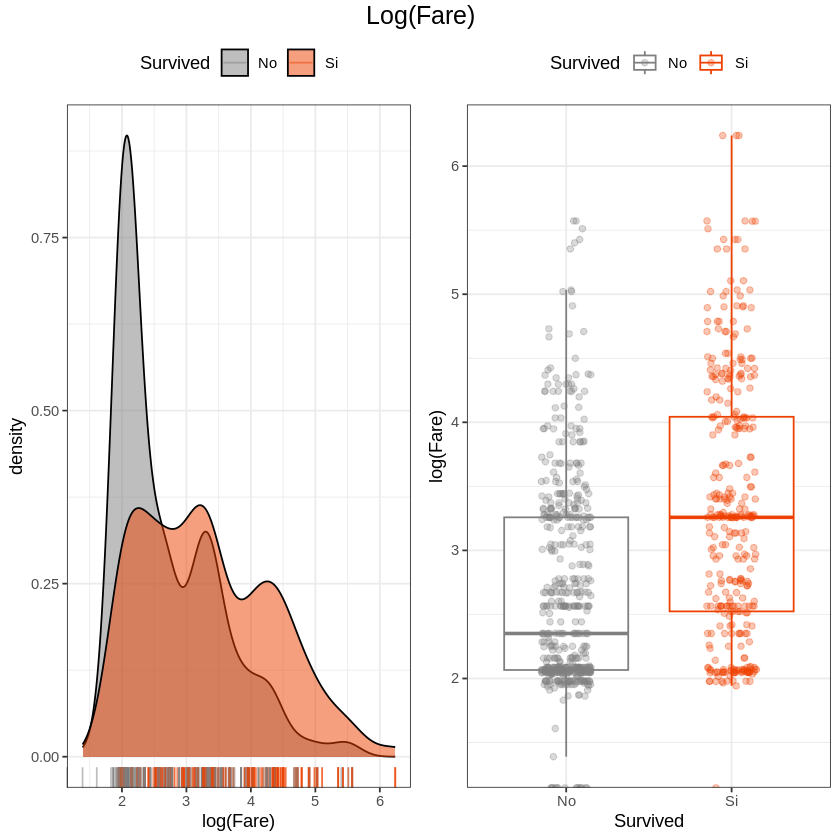

In [38]:
p1 <- ggplot(data = datos, aes(x = log(Fare), fill = Survived)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2")) +
      geom_rug(aes(color = Survived), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
p2 <- ggplot(data = datos, aes(x = Survived, y = log(Fare), color = Survived)) +
      geom_boxplot(outlier.shape = NA) +
      geom_jitter(alpha = 0.3, width = 0.15) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
final_plot <- ggarrange(p1, p2, legend = "top")
final_plot <- annotate_figure(final_plot, top = text_grob("Log(Fare)", size =15))
final_plot

## Distribución de variables cualitativas

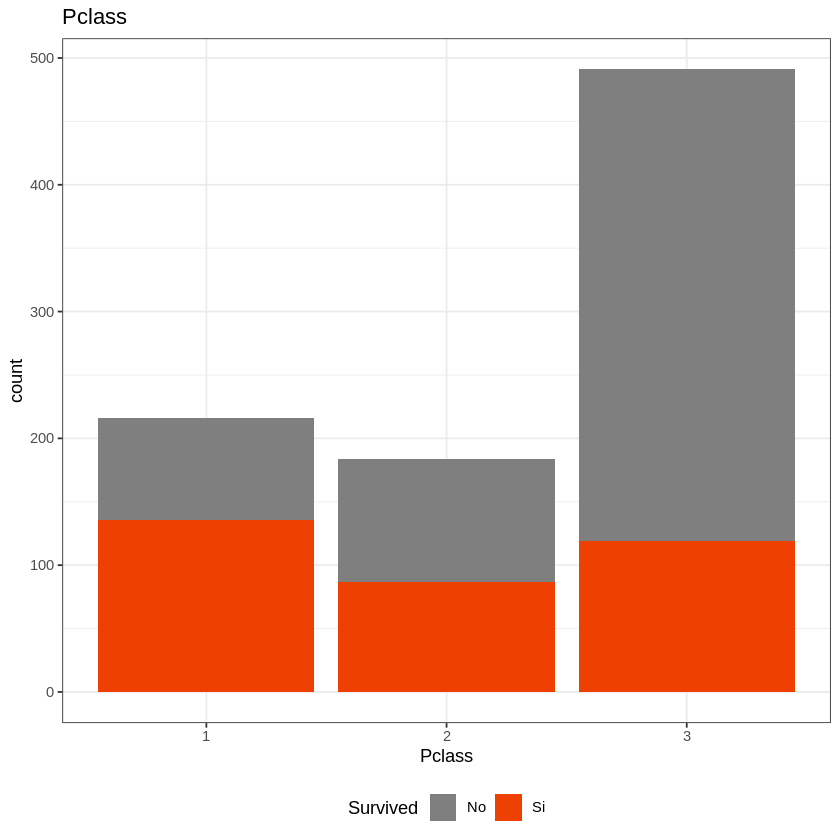

In [39]:
ggplot(data = datos, aes(x = Pclass, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Pclass") +
  theme_bw() +
  theme(legend.position = "bottom")

In [40]:
# Tabla de frecuencias relativas de supervivientes por clase
prop.table(table(datos$Pclass, datos$Survived), margin = 1) %>% round(digits = 2)

   
      No   Si
  1 0.37 0.63
  2 0.53 0.47
  3 0.76 0.24

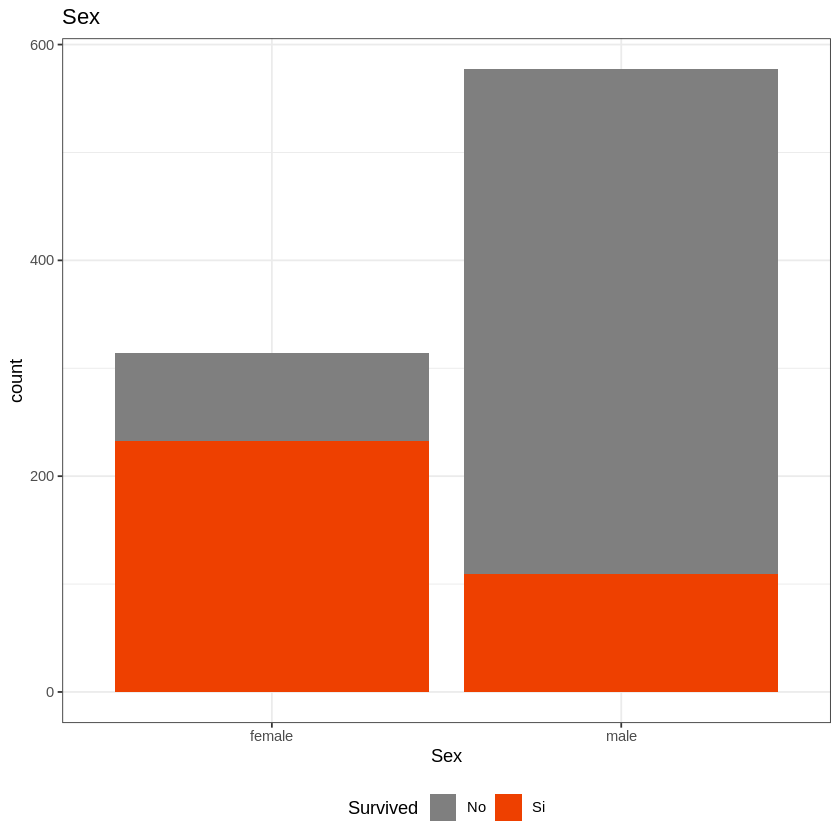

In [41]:
ggplot(data = datos, aes(x = Sex, y = ..count.., fill = Survived)) +
  geom_bar() +
  labs(title = "Sex") +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  theme_bw() +
  theme(legend.position = "bottom")

In [42]:
# Tabla de frecuencias relativas de supervivientes por sexo
prop.table(table(datos$Sex, datos$Survived), margin = 1) %>% round(digits = 2)

        
           No   Si
  female 0.26 0.74
  male   0.81 0.19

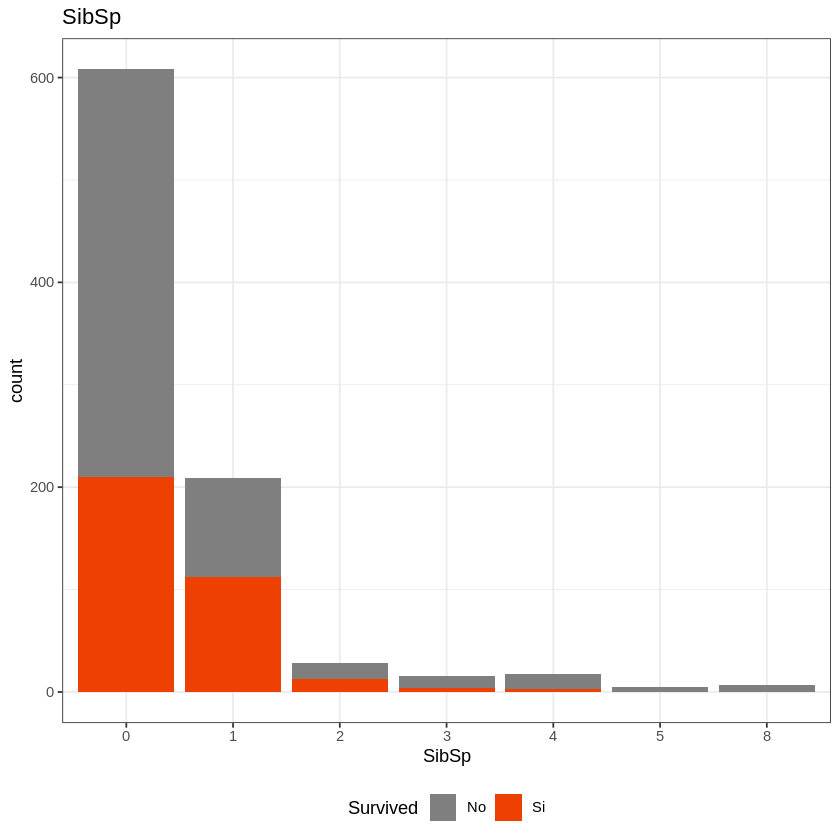

In [43]:
ggplot(data = datos, aes(x = SibSp, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "SibSp") +
  theme_bw() +
  theme(legend.position = "bottom")

In [44]:
# Tabla de frecuencias relativas de supervivientes por número de familiares
prop.table(table(datos$SibSp, datos$Survived), margin = 1) %>% round(digits = 2)

   
      No   Si
  0 0.65 0.35
  1 0.46 0.54
  2 0.54 0.46
  3 0.75 0.25
  4 0.83 0.17
  5 1.00 0.00
  8 1.00 0.00

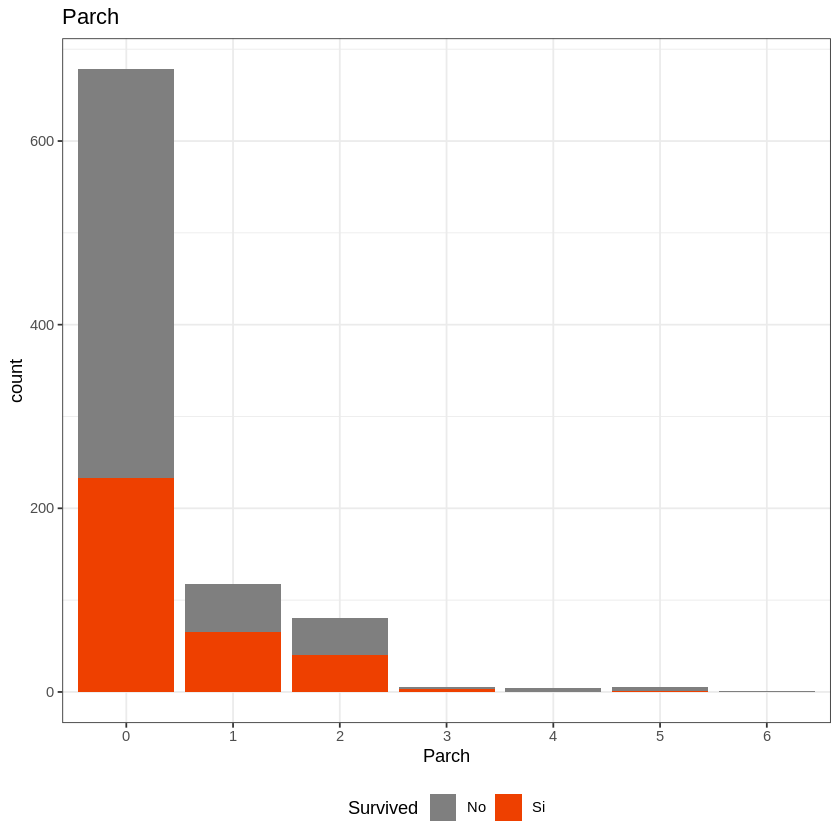

In [45]:
ggplot(data = datos, aes(x = Parch, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Parch") +
  theme_bw() +
  theme(legend.position = "bottom")

In [46]:
# Tabla de frecuencias relativas de supervivientes por Parch
prop.table(table(datos$Parch, datos$Survived), margin = 1) %>% round(digits = 2)

   
      No   Si
  0 0.66 0.34
  1 0.45 0.55
  2 0.50 0.50
  3 0.40 0.60
  4 1.00 0.00
  5 0.80 0.20
  6 1.00 0.00

In [47]:
# Para pasar de factor a numeric primero se convierte a character
datos$SibSp <- as.character(datos$SibSp)
datos$SibSp <- as.numeric(datos$SibSp)
datos$Parch <- as.character(datos$Parch)
datos$Parch <- as.numeric(datos$Parch)

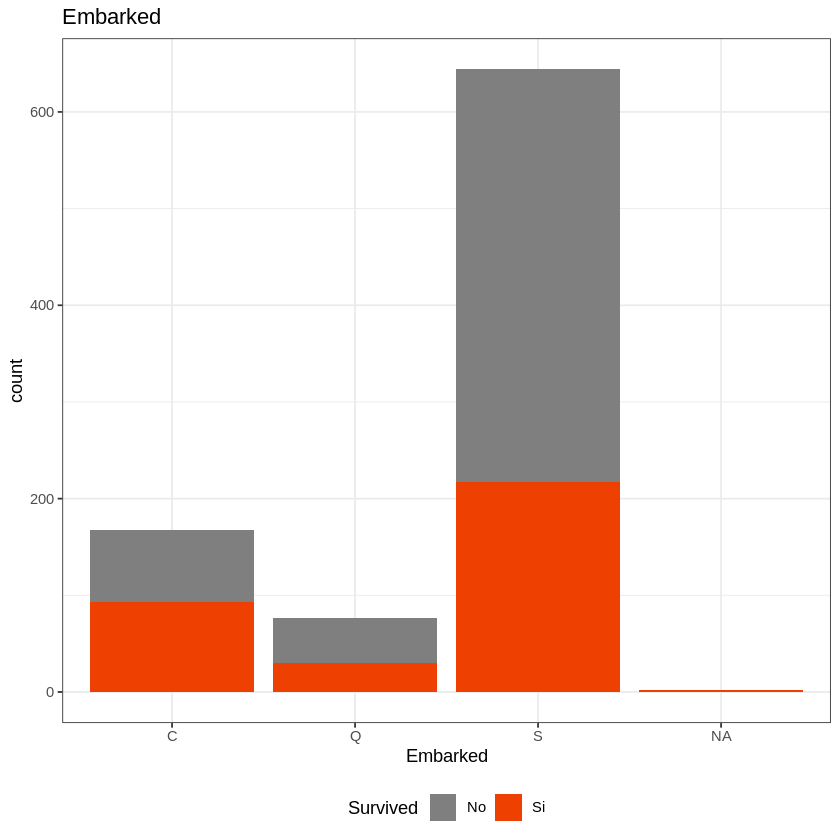

In [48]:
ggplot(data = datos, aes(x = Embarked, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Embarked") +
  theme_bw() +
  theme(legend.position = "bottom")

In [49]:
# Tabla de frecuencias relativas de supervivientes por puerto de embarque
prop.table(table(datos$Embarked, datos$Survived), margin = 1) %>% round(digits = 2)

   
      No   Si
  C 0.45 0.55
  Q 0.61 0.39
  S 0.66 0.34

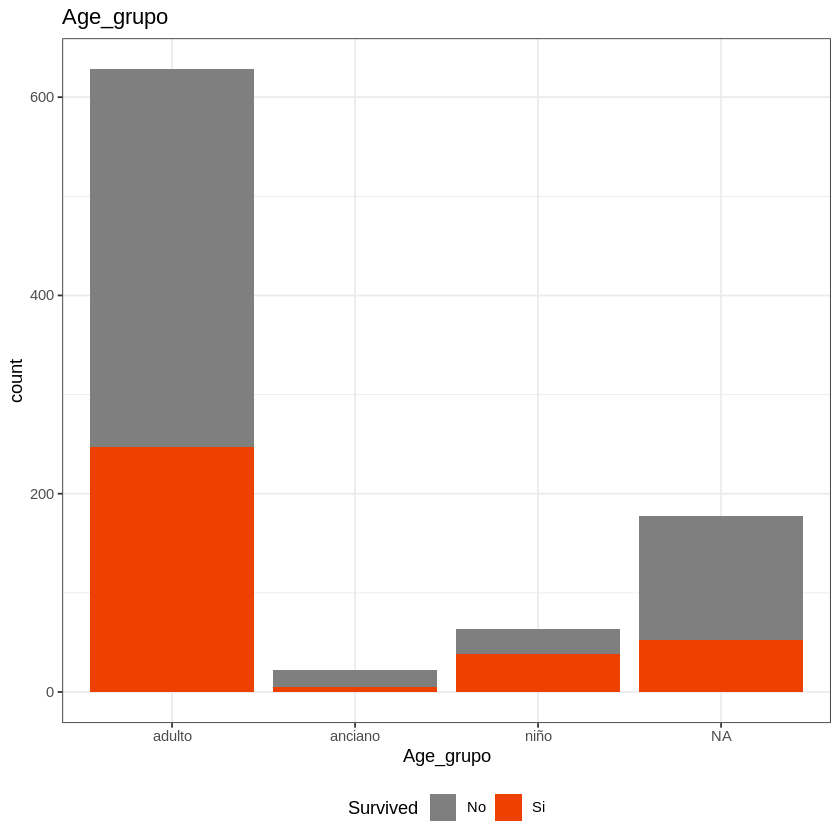

In [50]:
ggplot(data = datos, aes(x = Age_grupo, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Age_grupo") +
  theme_bw() +
  theme(legend.position = "bottom")

In [51]:
# Tabla de frecuencias relativas de supervivientes por grupo de edad
prop.table(table(datos$Age_grupo, datos$Survived), margin = 1) %>% round(digits = 2)

         
            No   Si
  adulto  0.61 0.39
  anciano 0.77 0.23
  niño    0.41 0.59

## Importancia de las variables

### Correlación entre variables continuas

In [52]:
cor.test(x = datos$Age, y = datos$Fare, method = "pearson")


	Pearson's product-moment correlation

data:  datos$Age and datos$Fare
t = 2.5753, df = 712, p-value = 0.01022
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02285549 0.16825304
sample estimates:
       cor 
0.09606669 


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 184 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 177 rows containing missing values (`geom_point()`).”


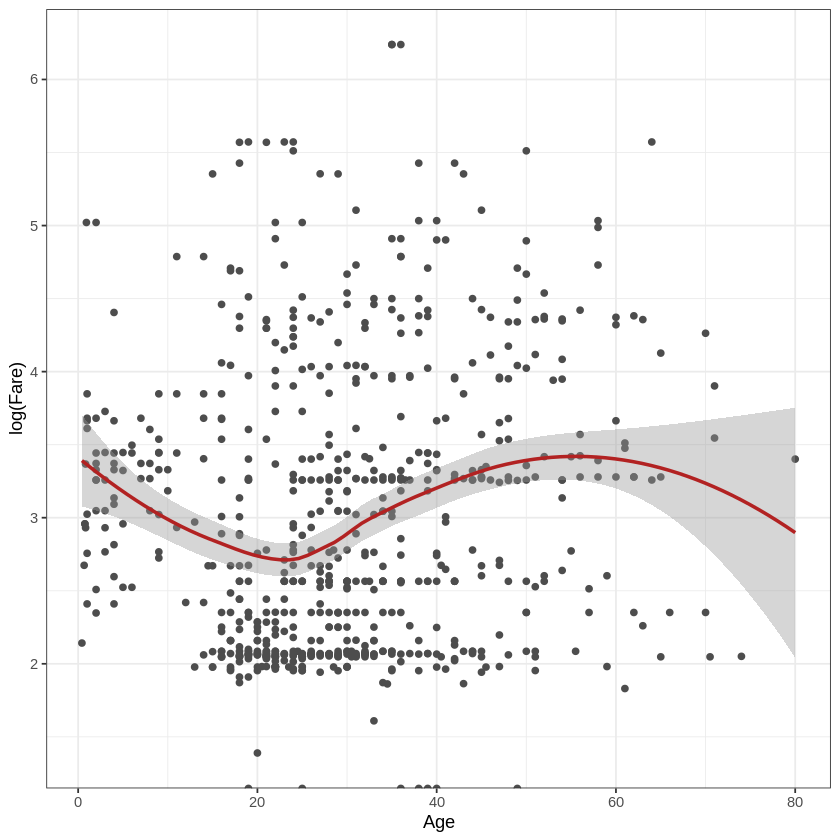

In [53]:
ggplot(data = datos, aes(x = Age, y = log(Fare))) +
  geom_point(color = "gray30") +
  geom_smooth(color = "firebrick") +
  theme_bw()


### Contraste de proporciones

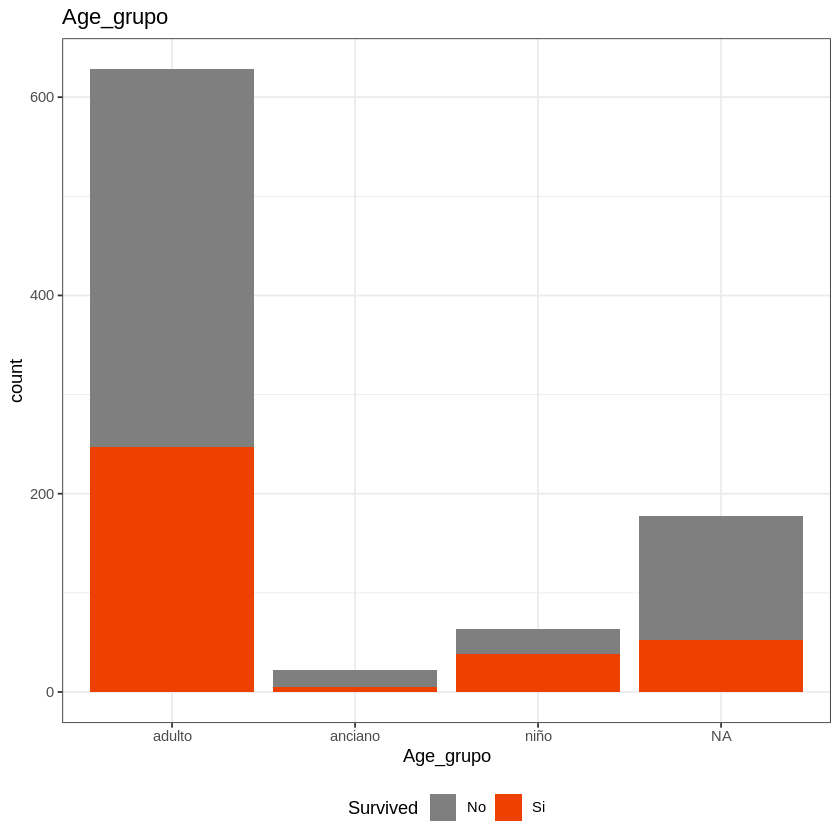

In [54]:
ggplot(data = datos, aes(x = Age_grupo, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Age_grupo") +
  theme_bw() +
  theme(legend.position = "bottom")

In [55]:
# Se excluyen las variables continuas y las cualitativas que no agrupan a los
# pasajeros. También la variable Cabin por su alto % de valores NA.
datos_cualitativos <- datos %>%
                      select(-Age, -Fare, -Name, -Ticket, -Cabin, -PassengerId)

datos_cualitativos_tidy <- datos_cualitativos %>%
                           gather(key = "variable", value = "grupo",-Survived)

# Se eliminan los valores NA para que no se interpreten como un grupo
datos_cualitativos_tidy <- datos_cualitativos_tidy %>% filter(!is.na(grupo))

# Se añade un identificador formado por el nombre de la variable y el grupo
datos_cualitativos_tidy <- datos_cualitativos_tidy %>%
                           mutate(variable_grupo = paste(variable, grupo, sep = "_"))

Warning message:
“attributes are not identical across measure variables; they will be dropped”


In [56]:
# Función que calcula el test de proporciones para la columna "Survived" de un df
test_proporcion <- function(df){
  n_supervivientes <- sum(df$Survived == "Si")
  n_fallecidos     <- sum(df$Survived == "No")
  n_total <- n_supervivientes + n_fallecidos
  test <- prop.test(x = n_supervivientes, n = n_total, p = 0.3838)
  prop_supervivientes <- n_supervivientes / n_total
  return(data.frame(p_value = test$p.value, prop_supervivientes))
}

# Se agrupan los datos por "variable_grupo" y se aplica a cada grupo la función
# test_proporcion()
analisis_prop <- datos_cualitativos_tidy %>%
                 group_by(variable_grupo) %>%
                 nest() %>%
                 arrange(variable_grupo) %>%
                 mutate(prop_test = map(.x = data, .f = test_proporcion)) %>%
                 unnest(prop_test) %>%
                 arrange(p_value) %>%
                 select(variable_grupo,p_value, prop_supervivientes)
analisis_prop

Warning message:
“There were 6 warnings in `mutate()`.
The first warning was:
ℹ In argument: `prop_test = map(.x = data, .f = test_proporcion)`.
ℹ In group 10: `variable_grupo = "Parch_3"`.
Caused by warning in `prop.test()`:
! Chi-squared approximation may be incorrect
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”


variable_grupo,p_value,prop_supervivientes
<chr>,<dbl>,<dbl>
Sex_female,1.299761e-38,0.7420382
Sex_male,9.363458e-22,0.1889081
Pclass_1,1.848202e-13,0.6296296
Pclass_3,1.572811e-10,0.2423625
SibSp_1,8.586710e-06,0.5358852
Embarked_C,8.766955e-06,0.5535714
Parch_1,2.761378e-04,0.5508475
Age_grupo_niño,8.834112e-04,0.5937500
Pclass_2,1.606610e-02,0.4728261


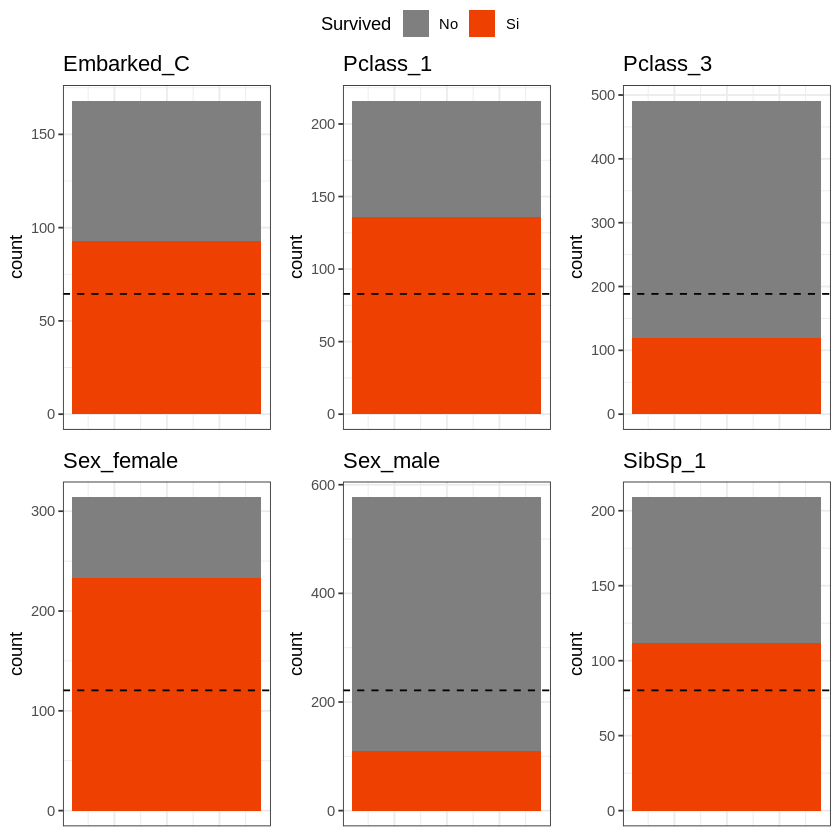

In [57]:
# Representación gráfica de la distribución de los 6 grupos con menor p-value
top6_grupos <- analisis_prop %>% pull(variable_grupo) %>% head(6)

# Se crea una función que, dados un dataframe y el nombre de un grupo, genere la
# representación gráfica de supervivientes y no supervivientes.
plot_grupo <- function(grupo, df, threshold_line = 0.3838){

  p <- ggplot(data = df, aes(x = 1, y = ..count.., fill = Survived)) +
            geom_bar() +
            scale_fill_manual(values = c("gray50", "orangered2")) +
            # Se añade una línea horizontal en el nivel basal
            geom_hline(yintercept = nrow(df) * threshold_line,
                       linetype = "dashed") +
            labs(title = grupo) +
            theme_bw() +
            theme(legend.position = "bottom",
                  axis.text.x = element_blank(),
                  axis.title.x = element_blank(),
                  axis.ticks.x = element_blank())
  return(p)
}

datos_graficos <- datos_cualitativos_tidy %>%
                  filter(variable_grupo %in% top6_grupos) %>%
                  group_by(variable_grupo) %>%
                  nest() %>%
                  arrange(variable_grupo)

plots <- map2(datos_graficos$variable_grupo, .y = datos_graficos$data,
              .f = plot_grupo)

ggarrange(plotlist = plots, common.legend = TRUE)



### Random forest

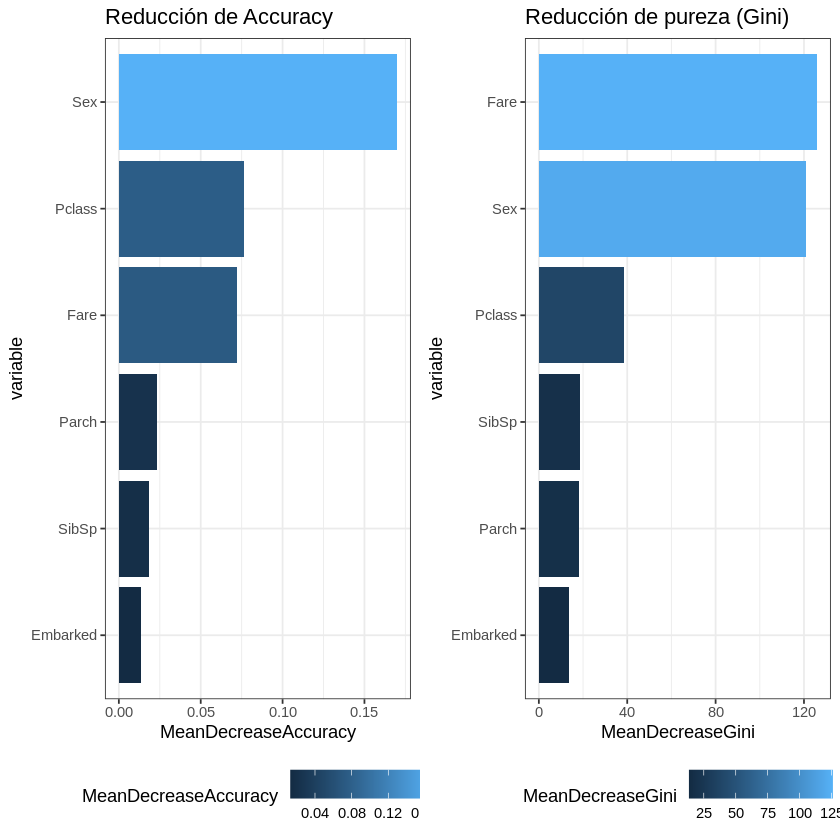

In [58]:
library(randomForest)
datos_rf <- datos %>%
            select(-PassengerId, -Name, -Ticket, -Cabin, -Age, -Age_grupo) %>%
            na.omit()
datos_rf <- map_if(.x = datos_rf, .p = is.character, .f = as.factor) %>%
            as.data.frame()
modelo_randforest <- randomForest(formula = Survived ~ . ,
                                  data = na.omit(datos_rf),
                                  mtry = 5,
                                  importance = TRUE,
                                  ntree = 1000)
importancia <- as.data.frame(modelo_randforest$importance)
importancia <- rownames_to_column(importancia,var = "variable")

p1 <- ggplot(data = importancia, aes(x = reorder(variable, MeanDecreaseAccuracy),
                               y = MeanDecreaseAccuracy,
                               fill = MeanDecreaseAccuracy)) +
      labs(x = "variable", title = "Reducción de Accuracy") +
      geom_col() +
      coord_flip() +
      theme_bw() +
      theme(legend.position = "bottom")

p2 <- ggplot(data = importancia, aes(x = reorder(variable, MeanDecreaseGini),
                               y = MeanDecreaseGini,
                               fill = MeanDecreaseGini)) +
      labs(x = "variable", title = "Reducción de pureza (Gini)") +
      geom_col() +
      coord_flip() +
      theme_bw() +
      theme(legend.position = "bottom")
ggarrange(p1, p2)

# División de los datos en entrenamiento y test

In [59]:
set.seed(123)
# Se crean los índices de las observaciones de entrenamiento
train <- createDataPartition(y = datos$Survived, p = 0.8, list = FALSE, times = 1)
datos_train <- datos[train, ]
datos_test  <- datos[-train, ]

In [60]:
prop.table(table(datos_train$Survived))


       No        Si 
0.6162465 0.3837535 

In [61]:
prop.table(table(datos_test$Survived))


       No        Si 
0.6158192 0.3841808 

# Preprocesado de los datos


## Imputación de valores ausentes


In [62]:
nrow(datos)

[1] 891

In [63]:
nrow(na.omit(datos))

[1] 183

In [64]:
datos_train <- datos_train %>%
               mutate(Embarked = replace(Embarked, is.na(Embarked), "C"))
datos_test <-  datos_test %>%
               mutate(Embarked = replace(Embarked, is.na(Embarked), "C"))

In [65]:
library(recipes)
# Se crea un objeto recipe() con la variable respuesta y los predictores.
# Las variables *PassengerId*, *Name*, *Ticket* no parecen aportar información
# relevante sobre la supervivencia de los pasajeros. Excluyendo todas estas
# variables, se propone como modelo inicial el formado por los predictores:
#  Pclass + Sex + SibSp + Parch + Fare + Embarked + Age_grupo.

objeto_recipe <- recipe(formula = Survived ~ Pclass + Sex + SibSp + Parch +
                                  Fare + Embarked + Age_grupo,
                        data =  datos_train)
objeto_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 7



In [66]:
objeto_recipe <- objeto_recipe %>% step_impute_bag(Age_grupo)
objeto_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 7



── Operations 

• Bagged tree imputation for: Age_grupo



## Variables con varianza próxima a cero

In [67]:
datos %>% select(Pclass, Sex, SibSp, Parch, Fare, Embarked, Age_grupo) %>%
          nearZeroVar(saveMetrics = TRUE)

,freqRatio,percentUnique,zeroVar,nzv
,<dbl>,<dbl>,<lgl>,<lgl>
Pclass,2.273148,0.3367003,FALSE,FALSE
Sex,1.837580,0.2244669,FALSE,FALSE
SibSp,2.909091,0.7856341,FALSE,FALSE
Parch,5.745763,0.7856341,FALSE,FALSE
Fare,1.023810,27.8338945,FALSE,FALSE
Embarked,3.833333,0.3367003,FALSE,FALSE
Age_grupo,9.812500,0.3367003,FALSE,FALSE


In [68]:
objeto_recipe <- objeto_recipe %>% step_nzv(all_predictors())

## Estandarización y escalado

In [69]:
objeto_recipe <- objeto_recipe %>% step_center(all_numeric())
objeto_recipe <- objeto_recipe %>% step_scale(all_numeric())

## Binarización de variables cualitativas

In [70]:
objeto_recipe <- objeto_recipe %>% step_dummy(all_nominal(), -all_outcomes())

In [71]:
# Se entrena el objeto recipe
trained_recipe <- prep(objeto_recipe, training = datos_train)
trained_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 7



── Training information 

Training data contained 714 data points and 145 incomplete rows.



── Operations 

• Bagged tree imputation for: Age_grupo | Trained

• Sparse, unbalanced variable filter removed: <none> | Trained

• Centering for: SibSp, Parch, Fare | Trained

• Scaling for: SibSp, Parch, Fare | Trained

• Dummy variables from: Pclass, Sex, Embarked, Age_grupo | Trained



In [72]:
# Se aplican las transformaciones al conjunto de entrenamiento y de test
datos_train_prep <- bake(trained_recipe, new_data = datos_train)
datos_test_prep  <- bake(trained_recipe, new_data = datos_test)

glimpse(datos_train_prep)

Rows: 714
Columns: 11
$ SibSp             <dbl> -0.4679339, -0.4679339, -0.4679339, -0.4679339, 2.48…
$ Parch             <dbl> -0.4618939, -0.4618939, -0.4618939, -0.4618939, 0.75…
$ Fare              <dbl> -0.521565287, -0.518757526, -0.509586256, 0.46536266…
$ Survived          <fct> Si, No, No, No, No, Si, Si, Si, No, No, No, Si, Si, …
$ Pclass_X2         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0…
$ Pclass_X3         <dbl> 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1…
$ Sex_male          <dbl> 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0…
$ Embarked_Q        <dbl> 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1…
$ Embarked_S        <dbl> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0…
$ Age_grupo_anciano <dbl> 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Age_grupo_niño    <dbl> 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…


## Selección de predictores

### Métodos wrapper

#### Eliminación recursiva de variables

In [73]:
# ELIMINACIÓN RECURSIVA MEDIANTE RANDOM FOREST Y BOOTSTRAPPING
# =============================================================================

# Se paraleliza el proceso para que sea más rápido. El número de cores debe
# seleccionarse en función del ordenador que se está empleando.
library(doMC)
registerDoMC(cores = 4)

# Tamaño de los conjuntos de predictores analizados
subsets <- c(3:11)

# Número de resamples para el proceso de bootstrapping
repeticiones <- 30

# Se crea una semilla para cada repetición de validación. Esto solo es necesario si
# se quiere asegurar la reproducibilidad de los resultados, ya que la validación
# cruzada y el bootstrapping implican selección aleatoria.

# El número de semillas necesarias depende del número total de repeticiones:
# Se necesitan B+1 elementos donde B es el número total de particiones (CV) o
# resampling (bootstrapping). Los primeros B elementos deben ser vectores formados
# por M números enteros, donde M es el número de modelos ajustados, que en este caso
# se corresponde con el número de tamaños. El último elemento solo necesita un único
# número para ajustar el modelo final.
set.seed(123)
seeds <- vector(mode = "list", length = repeticiones + 1)
for (i in 1:repeticiones) {
  seeds[[i]] <- sample.int(1000, length(subsets))
}
seeds[[repeticiones + 1]] <- sample.int(1000, 1)

# Se crea un control de entrenamiento donde se define el tipo de modelo empleado
# para la selección de variables, en este caso random forest, la estrategia de
# resampling, en este caso bootstrapping con 30 repeticiones, y las semillas para
# cada repetición. Con el argumento returnResamp = "all" se especifica que se
# almacene la información de todos los modelos generados en todas las repeticiones.
ctrl_rfe <- rfeControl(functions = rfFuncs, method = "boot", number = repeticiones,
                       returnResamp = "all", allowParallel = TRUE, verbose = FALSE,
                       seeds = seeds)

# Se ejecuta la eliminación recursiva de predictores
set.seed(342)
rf_rfe <- rfe(Survived ~ ., data = datos_train_prep,
              sizes = subsets,
              metric = "Accuracy",
              # El accuracy es la proporción de clasificaciones correctas
              rfeControl = ctrl_rfe,
              ntree = 500)
# Dentro de rfe() se pueden especificar argumentos para el modelo empleado, por
# ejemplo, el hiperparámetro ntree=500.

In [74]:
# Se muestra una tabla resumen con los resultados
rf_rfe


Recursive feature selection

Outer resampling method: Bootstrapped (30 reps) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         3   0.7973 0.5577    0.02728 0.05625         
         4   0.8199 0.6041    0.02259 0.04918         
         5   0.8189 0.6031    0.01894 0.04365         
         6   0.8196 0.6048    0.01942 0.04339         
         7   0.8223 0.6109    0.01874 0.04255         
         8   0.8211 0.6068    0.01868 0.04255         
         9   0.8240 0.6169    0.02015 0.04524         
        10   0.8290 0.6262    0.02123 0.04838        *

The top 5 variables (out of 10):
   Sex_male, Fare, Age_grupo_niño, Pclass_X3, SibSp


In [75]:
# El objeto rf_rfe almacena en optVariables las variables del mejor modelo.
rf_rfe$optVariables

[1] "Sex_male"          "Fare"              "Age_grupo_niño"   
 [4] "Pclass_X3"         "SibSp"             "Embarked_S"       
 [7] "Parch"             "Pclass_X2"         "Age_grupo_anciano"
[10] "Embarked_Q"

In [76]:
# Valores de accuracy y kappa para cada tamaño de modelo en cada resample.
rf_rfe$resample %>% select(1, 2, 3, 8) %>% head(8)

,Variables,Accuracy,Kappa,Resample
,<int>,<dbl>,<dbl>,<chr>
1,3,0.7924528,0.5669291,Resample01
2,4,0.8301887,0.6365105,Resample01
3,5,0.8377358,0.6504065,Resample01
4,6,0.8377358,0.6526656,Resample01
5,7,0.8339623,0.6451613,Resample01
6,8,0.8490566,0.6784566,Resample01
7,9,0.8490566,0.6835443,Resample01
8,10,0.8641509,0.7133758,Resample01


In [77]:
# Métricas promedio de cada tamaño
rf_rfe$resample %>% group_by(Variables) %>%
                    summarise(media_accuracy = mean(Accuracy),
                              media_kappa = mean(Kappa)) %>%
                    arrange(desc(media_accuracy))


Variables,media_accuracy,media_kappa
<int>,<dbl>,<dbl>
10,0.8289744,0.6262429
9,0.8240500,0.6169338
7,0.8223151,0.6108504
8,0.8211453,0.6067893
4,0.8198799,0.6041396
6,0.8195946,0.6048459
5,0.8189425,0.6031466
3,0.7973284,0.5576582


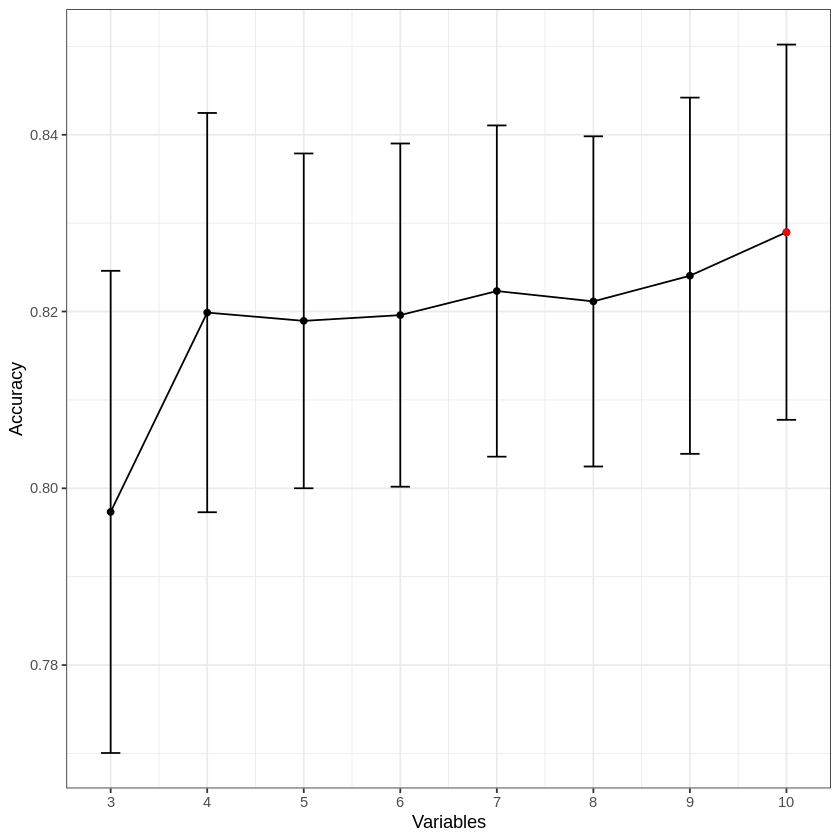

In [78]:
ggplot(data = rf_rfe$results, aes(x = Variables, y = Accuracy)) +
  geom_line() +
  scale_x_continuous(breaks  = unique(rf_rfe$results$Variables)) +
  geom_point() +
  geom_errorbar(aes(ymin = Accuracy - AccuracySD, ymax = Accuracy + AccuracySD),
                width = 0.2) +
  geom_point(data = rf_rfe$results %>% slice(which.max(Accuracy)),
             color = "red") +
  theme_bw()

In [79]:
head(rf_rfe$variables, 10)

,No,Si,Overall,var,Variables,Resample
,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,67.933933,67.933933,67.933933,Sex_male,10,Resample01
2,32.204548,32.204548,32.204548,Fare,10,Resample01
3,24.237873,24.237873,24.237873,Age_grupo_niño,10,Resample01
4,21.697684,21.697684,21.697684,Pclass_X3,10,Resample01
5,19.064933,19.064933,19.064933,Parch,10,Resample01
6,14.493424,14.493424,14.493424,Embarked_S,10,Resample01
7,14.368238,14.368238,14.368238,Pclass_X2,10,Resample01
8,14.164881,14.164881,14.164881,SibSp,10,Resample01
9,9.909584,9.909584,9.909584,Embarked_Q,10,Resample01


In [80]:
rf_rfe$variables %>% filter(Variables == 10) %>% group_by(var) %>%
                     summarise(media_influencia = mean(Overall),
                               sd_influencia = sd(Overall)) %>%
                     arrange(desc(media_influencia))

var,media_influencia,sd_influencia
<chr>,<dbl>,<dbl>
Sex_male,70.737516,5.771630
Fare,27.876097,3.339543
Age_grupo_niño,22.989408,3.442612
Pclass_X3,22.525093,1.761828
SibSp,18.334823,2.677700
Parch,15.666499,2.158862
Embarked_S,15.202801,3.528837
Pclass_X2,11.077965,1.477206
Age_grupo_anciano,8.462854,2.706773


#### Algoritmo genético

In [81]:
# Paralelización
# =============================================================================
library(doMC)
registerDoMC(cores = 4)

# Control de entrenamiento
# =============================================================================
ga_ctrl <- gafsControl(functions = rfGA,
                       method = "cv",
                       number = 5,
                       allowParallel = TRUE,
                       genParallel = TRUE,
                       verbose = FALSE)

# Selección de predictores
# =============================================================================
set.seed(10)
rf_ga <- gafs(x = datos_train_prep %>% select(-Survived),
              y = datos_train_prep$Survived,
              iters = 10,
              popSize = 10,
              gafsControl = ga_ctrl,
              ntree = 100)

In [82]:
rf_ga


Genetic Algorithm Feature Selection

714 samples
10 predictors
2 classes: 'No', 'Si' 

Maximum generations: 10 
Population per generation: 10 
Crossover probability: 0.8 
Mutation probability: 0.1 
Elitism: 0 

Internal performance values: Accuracy, Kappa
Subset selection driven to maximize internal Accuracy 

External performance values: Accuracy, Kappa
Best iteration chose by maximizing external Accuracy 
External resampling method: Cross-Validated (5 fold) 

During resampling:
  * the top 5 selected variables (out of a possible 10):
    Age_grupo_niño (100%), Fare (100%), Pclass_X3 (100%), Sex_male (100%), Parch (60%)
  * on average, 6.8 variables were selected (min = 5, max = 10)

In the final search using the entire training set:
   * 7 features selected at iteration 1 including:
     SibSp, Parch, Fare, Pclass_X3, Sex_male ... 
   * external performance at this iteration is

   Accuracy       Kappa 
     0.8249      0.6147 


In [83]:
rf_ga$optVariables

[1] "SibSp"          "Parch"          "Fare"           "Pclass_X3"     
[5] "Sex_male"       "Embarked_S"     "Age_grupo_niño"

In [84]:
# Accuracy media en cada generación
rf_ga$external %>% group_by(Iter) %>% summarize(accuracy_media = mean(Accuracy))

Iter,accuracy_media
<int>,<dbl>
1,0.8248990
2,0.8109130
3,0.8151088
4,0.8165074
5,0.8123116
6,0.8150990
7,0.8067074
8,0.8150990
9,0.8067172


In [85]:
crear_poblacion <- function(popSize, n_variables, n_max){
  # Esta función crea una matriz binaria en la que el número de 1s por
  # fila no supera un valor máximo.
  # Argumentos:
  #   popSize:     número total de individuos (número de filas de la matriz).
  #   n_variables: longitud de los individuos (número de columnas de la matriz).
  #   n_max:       número máximo de 1 que puede contener un individuo.

  # Matriz donde almacenar los individuos generados.
  poblacion <- matrix(data = NA, nrow = popSize, ncol = n_variables)

  # Bucle para crear cada individuo.
  for(i in 1:popSize){
    # Se selecciona con (igual probabilidad ) el número de valores = 1 que puede
    # tener el individuo.
    numero_1s <- sample(x = 1:n_max, size = 1)

    # Se crea un vector con todo ceros que representa el individuo.
    individuo <- rep(0, times = n_variables)

    # Se sustituyen (numero_1s) posiciones aleatorias por unos.
    individuo[sample(x = 1:n_variables, size = numero_1s)] <- 1

    # Se añade el nuevo individuo a la población.
    poblacion[i,] <- individuo
  }
    return(poblacion)
}

In [86]:
poblacion_inicial <- crear_poblacion(popSize = 10,
                                     n_variables = ncol(datos_train_prep) - 1 ,
                                     n_max = 4)
poblacion_inicial

0,0,0,0,1,1,1,1,0,0
0,0,1,0,1,0,1,0,0,1
1,0,0,0,0,1,0,1,0,1
0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0
0,0,1,0,0,1,1,1,0,0
0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,1,0,0


In [87]:
set.seed(10)
rf_ga <- gafs(x = datos_train_prep %>% select(-Survived),
              y = datos_train_prep$Survived,
              iters = 10,
              popSize = 10,
              suggestions = poblacion_inicial,
              gafsControl = ga_ctrl,
              ntree = 100)
rf_ga


Genetic Algorithm Feature Selection

714 samples
10 predictors
2 classes: 'No', 'Si' 

Maximum generations: 10 
Population per generation: 10 
Crossover probability: 0.8 
Mutation probability: 0.1 
Elitism: 0 

Internal performance values: Accuracy, Kappa
Subset selection driven to maximize internal Accuracy 

External performance values: Accuracy, Kappa
Best iteration chose by maximizing external Accuracy 
External resampling method: Cross-Validated (5 fold) 

During resampling:
  * the top 5 selected variables (out of a possible 10):
    Age_grupo_niño (100%), Embarked_S (100%), Sex_male (100%), Pclass_X3 (80%), Embarked_Q (60%)
  * on average, 5.2 variables were selected (min = 4, max = 6)

In the final search using the entire training set:
   * 4 features selected at iteration 1 including:
     SibSp, Sex_male, Embarked_S, Age_grupo_niño  
   * external performance at this iteration is

   Accuracy       Kappa 
     0.8179      0.6104 


### Métodos de filtrado

In [88]:
# FILTRADO DE PREDICTORES MEDIANTE ANOVA, RANDOM FOREST Y CV-REPETIDA
# =============================================================================

# Se paraleliza para que sea más rápido
library(doMC)
registerDoMC(cores = 4)

# Se crea una semilla para cada partición y cada repetición: el vector debe
# tener B+1 semillas donde B = particiones * repeticiones.
particiones = 10
repeticiones = 5
set.seed(123)
seeds <- sample.int(1000, particiones * repeticiones + 1)

# Control del filtrado
ctrl_filtrado <- sbfControl(functions = rfSBF, method = "repeatedcv",
                            number = particiones, repeats = repeticiones,
                            seeds = seeds, verbose = FALSE,
                            saveDetails = TRUE, allowParallel = TRUE)
set.seed(234)
rf_sbf <- sbf(Survived ~ ., data = datos_train_prep,
              sbfControl = ctrl_filtrado,
              # argumentos para el modelo de evaluación
              ntree = 500)

In [89]:
rf_sbf


Selection By Filter

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance:

 Accuracy  Kappa AccuracySD KappaSD
   0.8199 0.5986    0.04298 0.09951

Using the training set, 8 variables were selected:
   Parch, Fare, Pclass_X2, Pclass_X3, Sex_male...

During resampling, the top 5 selected variables (out of a possible 8):
   Age_grupo_anciano (100%), Age_grupo_niño (100%), Embarked_S (100%), Fare (100%), Pclass_X3 (100%)

On average, 7.6 variables were selected (min = 6, max = 8)

In [90]:
rf_sbf$optVariables

[1] "Parch"             "Fare"              "Pclass_X2"        
[4] "Pclass_X3"         "Sex_male"          "Embarked_S"       
[7] "Age_grupo_anciano" "Age_grupo_niño"

In [91]:
predictores_filtrados <- rf_sbf$optVariables

## Creación de un modelo predictivo

### Entrenamiento del modelo

In [92]:
install.packages(c("kernlab"))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [93]:
# Predictores: Survived, SibSp, Parch, Fare, Pclass_X2, Pclass_X3, Sex_male, Embarked_Q,
#              Embarked_S, Age_grupo_anciano, Age_grupo_niño
modelo_svmlineal <- train(Survived ~ ., method = "svmLinear", data = datos_train_prep)

In [94]:
modelo_svmlineal$finalModel

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Linear (vanilla) kernel function. 

Number of Support Vectors : 315 

Objective Function Value : -296.459 
Training error : 0.207283 

### Evaluación del modelo mediante resampling

In [95]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
# Se paraleliza para que sea más rápido. El número de cores activados depende del
# las características del ordenador donde se ejecute el código.
library(doMC)
registerDoMC(cores = 4)

# NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
# Es este caso se recurre a validación cruzada repetida como método de validación.
# Número de particiones y repeticiones
particiones  <- 10
repeticiones <- 5

# Las semillas solo son necesarias si se quiere asegurar la reproducibilidad de
# los resultados, ya que la validación cruzada y el bootstrapping implican selección
# aleatoria. Las semillas se almacenan en una lista con B+1 elementos donde B depende
# del método de validación empleado:
#
#   "cv": B es el número total de particiones
#   "repeatedcv": B es el número de particiones por el número de repeticiones.
#   "boot": B es el número de resamples.
#   "LOGOCV":   B es el número de repeticiones.
#
# Los primeros B elementos deben ser vectores formados por M números enteros,
# donde M es el número de modelos ajustados en cada partición o repetición,
# es decir, el total de hiperparámetros comparados. El último elemento (B+1) solo
# necesita un único número para ajustar el modelo final.

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  # Cada elemento de la lista, excepto el último tiene que tener tantas semillas
  # como hiperparámetros analizados. En este caso, se emplea el valor por
  # defecto C = 1, por lo que cada elemento de seeds está formada por un
  # único valor.
  seeds[[i]] <- sample.int(1000, 1)
}
# La última semilla se emplea para ajustar el modelo final con todas las observaciones.
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "all", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_svmlineal <- train(Survived ~ ., data = datos_train_prep,
                          method = "svmLinear",
                          metric = "Accuracy",
                          trControl = control_train)
modelo_svmlineal

Support Vector Machines with Linear Kernel 

714 samples
 10 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 643, 643, 643, 643, 642, ... 
Resampling results:

  Accuracy  Kappa    
  0.792766  0.5554307

Tuning parameter 'C' was held constant at a value of 1

In [96]:
# Valores de validación (Accuracy y Kappa) obtenidos en cada partición y repetición.
modelo_svmlineal$resample %>% head(10)

,Accuracy,Kappa,C,Resample
,<dbl>,<dbl>,<dbl>,<chr>
1,0.7777778,0.5068493,1,Fold01.Rep1
2,0.8450704,0.6640860,1,Fold02.Rep1
3,0.8028169,0.5693241,1,Fold03.Rep1
4,0.8169014,0.6030108,1,Fold04.Rep1
5,0.7887324,0.5281347,1,Fold05.Rep1
6,0.8055556,0.5855263,1,Fold06.Rep1
7,0.7916667,0.5700637,1,Fold07.Rep1
8,0.7042254,0.3679525,1,Fold08.Rep1
9,0.7777778,0.5384615,1,Fold09.Rep1


In [97]:
summary(modelo_svmlineal$resample$Accuracy)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6806  0.7639  0.8028  0.7928  0.8188  0.8889 

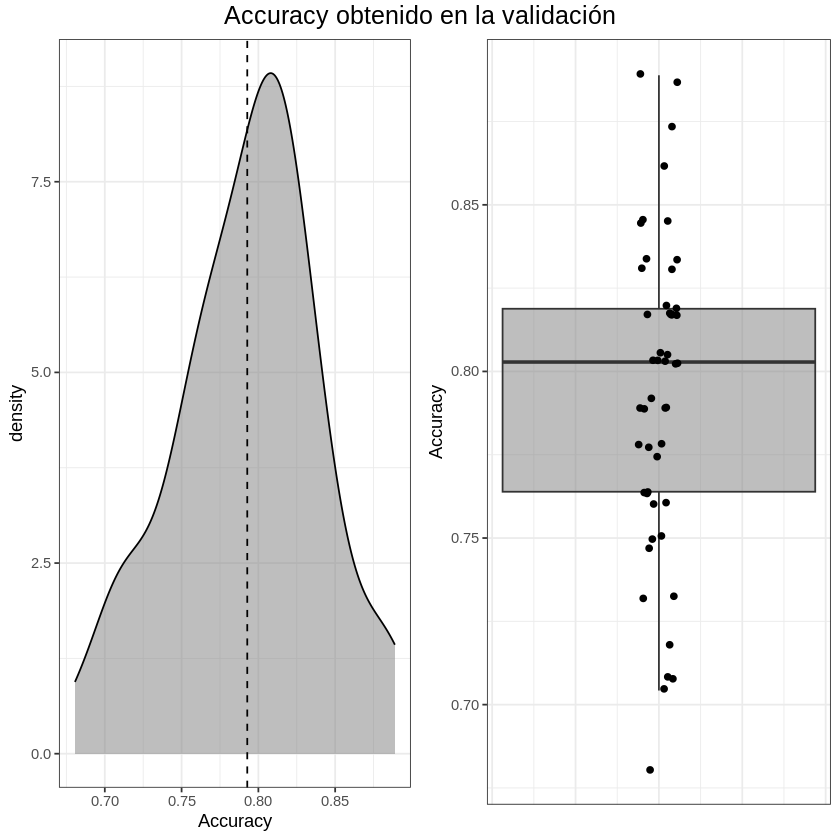

In [98]:
p1 <- ggplot(data = modelo_svmlineal$resample, aes(x = Accuracy)) +
      geom_density(alpha = 0.5, fill = "gray50") +
      geom_vline(xintercept = mean(modelo_svmlineal$resample$Accuracy),
                 linetype = "dashed") +
      theme_bw()
p2 <- ggplot(data = modelo_svmlineal$resample, aes(x = 1, y = Accuracy)) +
      geom_boxplot(outlier.shape = NA, alpha = 0.5, fill = "gray50") +
      geom_jitter(width = 0.05) +
      labs(x = "") +
      theme_bw() +
      theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())

final_plot <- ggarrange(p1, p2)
final_plot <- annotate_figure(
                final_plot,
                top = text_grob("Accuracy obtenido en la validación", size = 15))
final_plot

### Optimización de hiperparámetros (parameter tuning)


In [99]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

hiperparametros <- data.frame(C = c(0.001, 0.01, 0.1, 0.5, 1, 10))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "all", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_svmlineal <- train(Survived ~ ., data = datos_train_prep,
                          method = "svmLinear",
                          tuneGrid = hiperparametros,
                          metric = "Accuracy",
                          trControl = control_train)
modelo_svmlineal

Support Vector Machines with Linear Kernel 

714 samples
 10 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 643, 643, 643, 643, 642, ... 
Resampling results across tuning parameters:

  C      Accuracy   Kappa     
  1e-03  0.6308451  0.04826884
  1e-02  0.7927660  0.55543074
  1e-01  0.7927660  0.55543074
  5e-01  0.7927660  0.55543074
  1e+00  0.7927660  0.55543074
  1e+01  0.7927660  0.55543074

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 0.01.

In [100]:
modelo_svmlineal$resample %>% head()

,Accuracy,Kappa,C,Resample
,<dbl>,<dbl>,<dbl>,<chr>
1,0.6250000,0.04330709,1e-03,Fold01.Rep1
2,0.7777778,0.50684932,1e-02,Fold01.Rep1
3,0.7777778,0.50684932,1e-01,Fold01.Rep1
4,0.7777778,0.50684932,5e-01,Fold01.Rep1
5,0.7777778,0.50684932,1e+00,Fold01.Rep1
6,0.7777778,0.50684932,1e+01,Fold01.Rep1


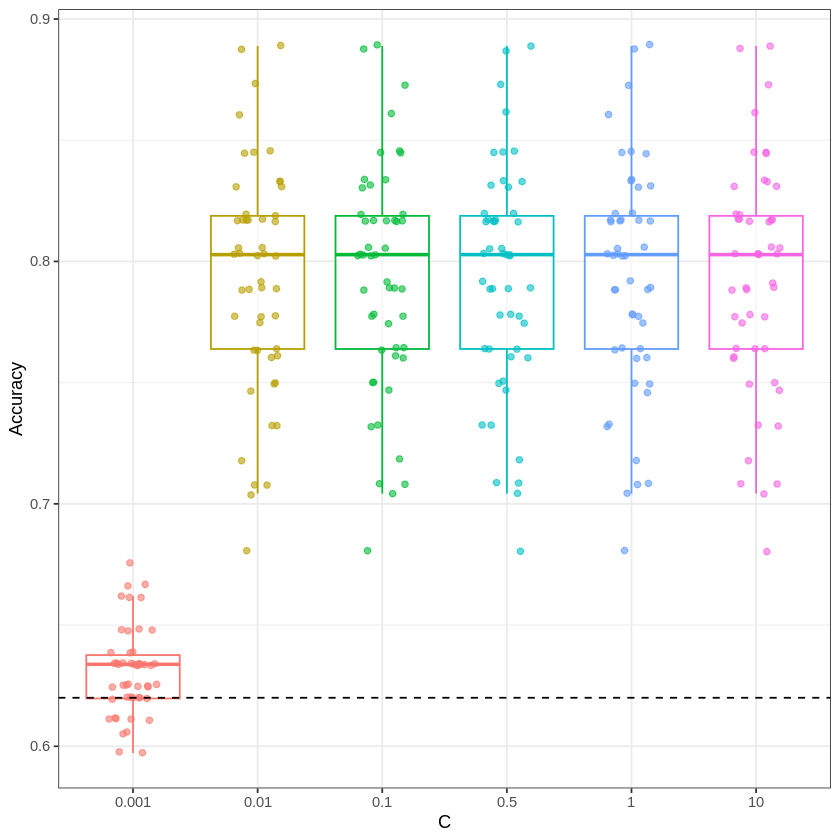

In [101]:
ggplot(data = modelo_svmlineal$resample,
       aes(x = as.factor(C), y = Accuracy, color = as.factor(C))) +
  geom_boxplot(outlier.shape = NA, alpha = 0.6) +
  geom_jitter(width = 0.2, alpha = 0.6) +
  # Línea horizontal en el accuracy basal
  geom_hline(yintercept = 0.62, linetype = "dashed") +
  labs(x = "C") +
  theme_bw() + theme(legend.position = "none")

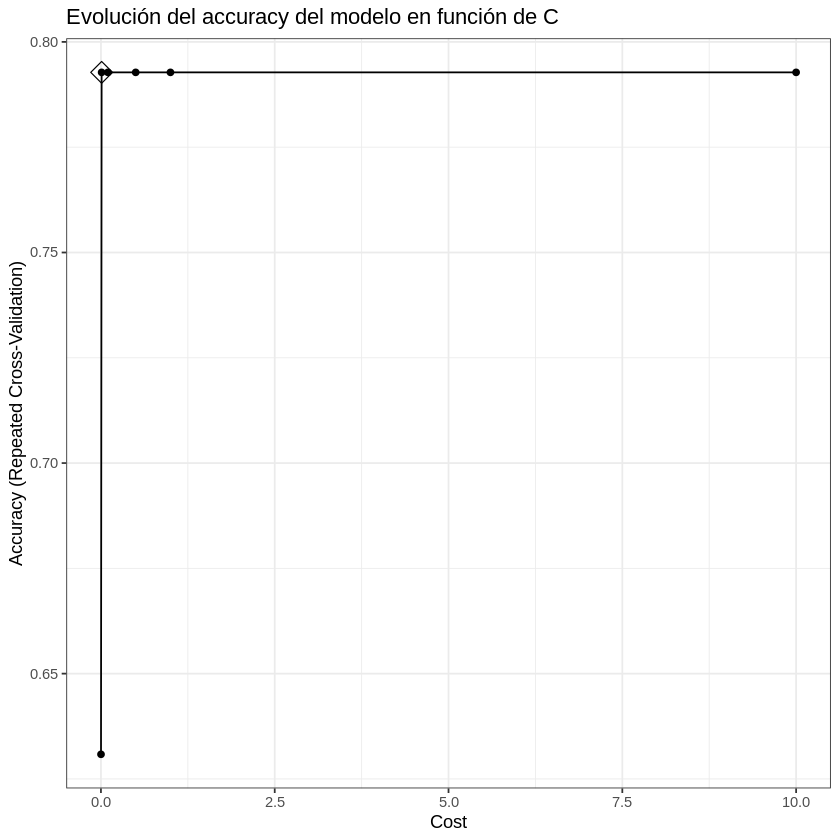

In [102]:
ggplot(modelo_svmlineal, highlight = TRUE) +
  labs(title = "Evolución del accuracy del modelo en función de C") +
  theme_bw()

#### Búsqueda de hiperparámetros

*Random search*

In [103]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros aleatorios
set.seed(123)
hiperparametros <- data.frame(C = runif(n = 5, min = 0.001, max = 20))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "all", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_svmlineal_random <- train(Survived ~ ., data = datos_train_prep,
                               method = "svmLinear",
                               tuneGrid = hiperparametros,
                               metric = "Accuracy",
                               trControl = control_train)

In [104]:
modelo_svmlineal_random

Support Vector Machines with Linear Kernel 

714 samples
 10 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 643, 643, 643, 643, 642, ... 
Resampling results across tuning parameters:

  C          Accuracy  Kappa    
   5.752263  0.792766  0.5554307
   8.180129  0.792766  0.5554307
  15.766314  0.792766  0.5554307
  17.660465  0.792766  0.5554307
  18.809405  0.792766  0.5554307

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 5.752263.

*Adaptive Resampling*



In [105]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Número de hiperparámetros aleatorios
n_hiperparametros <- 10

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, n_hiperparametros)
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "adaptive_cv", number = particiones,
                              repeats = repeticiones,
                              adaptive = list(min = 5, alpha = 0.05,
                                             method = "gls", complete = TRUE),
                              returnResamp = "all", verboseIter = FALSE,
                              allowParallel = TRUE, search = "random")

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_svmlineal_adaptative <- train(Survived ~ ., data = datos_train_prep,
                                 method = "svmLinear", trControl = control_train,
                                 tuneLength = 5)


Attaching package: ‘kernlab’


The following object is masked from ‘package:purrr’:

    cross


The following object is masked from ‘package:ggplot2’:

    alpha




In [106]:
modelo_svmlineal_adaptative

Support Vector Machines with Linear Kernel 

714 samples
 10 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Adaptively Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 643, 643, 643, 643, 642, ... 
Resampling results across tuning parameters:

  C            Accuracy   Kappa      Resamples
    0.2060751  0.7942816  0.5592503  49       
    2.7584259  0.7942816  0.5592503  49       
   22.9018044  0.7942816  0.5592503  49       
  337.3203713  0.7949210  0.5555385  11       
  357.7548716  0.7935994  0.5567193  50       

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 357.7549.

### Predicción

In [107]:
predicciones_raw <- predict(modelo_svmlineal, newdata = datos_test_prep,
                            type = "raw")
predicciones_raw

[1] No Si Si Si No No Si No Si Si Si No Si No Si No No Si Si Si No Si No No Si
 [26] No No Si No No Si Si Si No No No No No Si Si No No No Si Si No Si No No No
 [51] No No Si No No No Si No No No No Si No Si No No Si Si No No No Si Si Si No
 [76] Si No No No Si No No No No Si No Si No No No No No No No No No Si Si No No
[101] Si No No Si No No No No No No Si No No No Si No No No No No Si No No No Si
[126] No Si No No No No No No No No No Si No Si No No Si Si No No No No No No No
[151] Si No Si No Si No Si No No No Si Si No No No No Si No No Si Si Si Si No No
[176] No No
Levels: No Si

In [108]:
# El algoritmo svmLinear no calcula de forma nativa probabilidades, para obtenerlas
# se reajusta el modelo indicando `classProbs = TRUE`.
particiones  <- 10
repeticiones <- 5
hiperparametros <- expand.grid(C = c(1))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "all", verboseIter = FALSE,
                              classProbs = TRUE, allowParallel = TRUE)

set.seed(342)
modelo_svmlineal <- train(Survived ~ ., data = datos_train_prep,
                          method = "svmLinear",
                          tuneGrid = hiperparametros,
                          metric = "Accuracy",
                          trControl = control_train)

predicciones_prob <- predict(modelo_svmlineal, newdata = datos_test_prep,
                             type = "prob")
predicciones_prob %>% head()

,No,Si
,<dbl>,<dbl>
1,0.7996767,0.2003233
2,0.2667931,0.7332069
3,0.2668286,0.7331714
4,0.2667597,0.7332403
5,0.7995249,0.2004751
6,0.7995859,0.2004141


In [109]:
predicciones <- extractPrediction(
                  models = list(svm = modelo_svmlineal),
                  testX = datos_test_prep %>% select(-Survived),
                  testY = datos_test_prep$Survived
                  )
predicciones %>% head()

,obs,pred,model,dataType,object
,<fct>,<fct>,<chr>,<chr>,<chr>
1,Si,Si,svmLinear,Training,svm
2,No,No,svmLinear,Training,svm
3,No,No,svmLinear,Training,svm
4,No,No,svmLinear,Training,svm
5,No,No,svmLinear,Training,svm
6,Si,Si,svmLinear,Training,svm


### Error de test

In [110]:
confusionMatrix(data = predicciones_raw, reference = datos_test_prep$Survived,
                positive = "Si")

Confusion Matrix and Statistics

          Reference
Prediction No Si
        No 92 25
        Si 17 43
                                          
               Accuracy : 0.7627          
                 95% CI : (0.6931, 0.8233)
    No Information Rate : 0.6158          
    P-Value [Acc > NIR] : 2.393e-05       
                                          
                  Kappa : 0.4872          
                                          
 Mcnemar's Test P-Value : 0.2801          
                                          
            Sensitivity : 0.6324          
            Specificity : 0.8440          
         Pos Pred Value : 0.7167          
         Neg Pred Value : 0.7863          
             Prevalence : 0.3842          
         Detection Rate : 0.2429          
   Detection Prevalence : 0.3390          
      Balanced Accuracy : 0.7382          
                                          
       'Positive' Class : Si              
                                    

In [111]:
# Error de test
error_test <- mean(predicciones_raw != datos_test_prep$Survived)
paste("El error de test del modelo:", round(error_test*100, 2), "%")

[1] "El error de test del modelo: 23.73 %"

## Modelos

### K-Nearest Neighbor (kNN)

In [112]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- data.frame(k = c(1, 2, 5, 10, 15, 20, 30, 50))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_knn <- train(Survived ~ ., data = datos_train_prep,
                    method = "knn",
                    tuneGrid = hiperparametros,
                    metric = "Accuracy",
                    trControl = control_train)
modelo_knn

k-Nearest Neighbors 

714 samples
 10 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 643, 643, 643, 643, 642, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.7834977  0.5392593
   2  0.7916784  0.5601159
   5  0.7863576  0.5457335
  10  0.7888419  0.5505144
  15  0.7857864  0.5433513
  20  0.7700900  0.5020490
  30  0.7667371  0.4857700
  50  0.7440258  0.4255430

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 2.

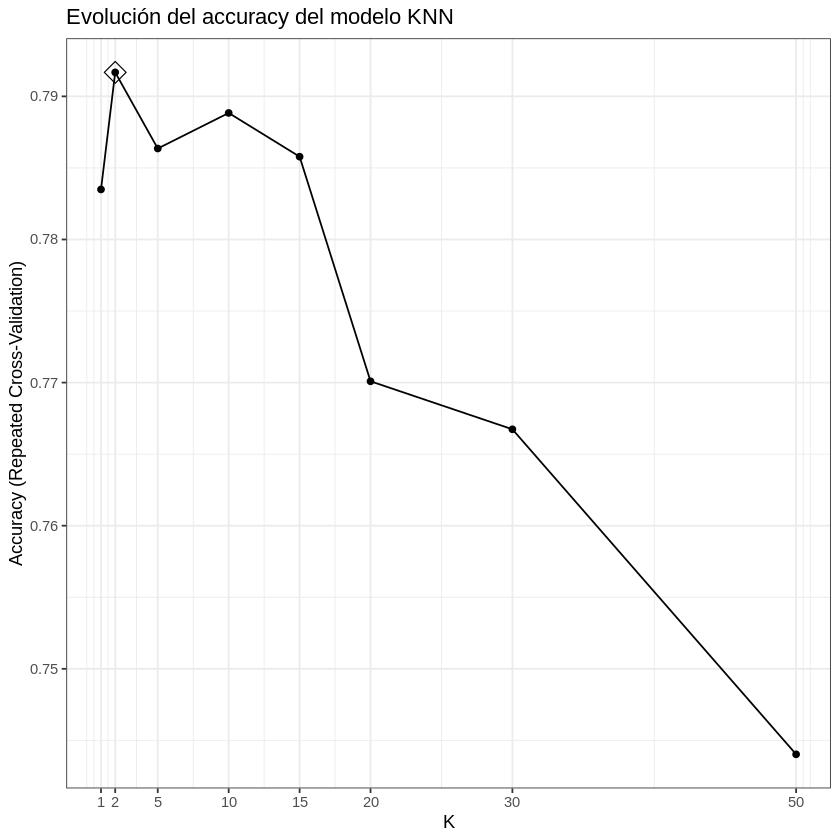

In [113]:
# REPRESENTACIÓN GRÁFICA
# ==============================================================================
ggplot(modelo_knn, highlight = TRUE) +
  scale_x_continuous(breaks = hiperparametros$k) +
  labs(title = "Evolución del accuracy del modelo KNN", x = "K") +
  theme_bw()

### Naive Bayes

In [115]:
install.packages("klaR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.methodsS3’, ‘R.oo’, ‘R.utils’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘promises’, ‘R.cache’, ‘shiny’, ‘miniUI’, ‘styler’, ‘classInt’, ‘labelled’, ‘combinat’, ‘questionr’




In [116]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- data.frame(usekernel = FALSE, fL = 0 , adjust = 0)

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_nb <- train(Survived ~ ., data = datos_train_prep,
                   method = "nb",
                   tuneGrid = hiperparametros,
                   metric = "Accuracy",
                   trControl = control_train)
modelo_nb

Naive Bayes 

714 samples
 10 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 643, 643, 643, 643, 642, ... 
Resampling results:

  Accuracy   Kappa    
  0.7877387  0.5568725

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'usekernel' was held constant at a value of FALSE
Tuning
 parameter 'adjust' was held constant at a value of 0

### Regresión logística


In [117]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- data.frame(parameter = "none")

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_logistic <- train(Survived ~ ., data = datos_train_prep,
                         method = "glm",
                         tuneGrid = hiperparametros,
                         metric = "Accuracy",
                         trControl = control_train,
                         family = "binomial")
modelo_logistic

Generalized Linear Model 

714 samples
 10 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 643, 643, 643, 643, 642, ... 
Resampling results:

  Accuracy   Kappa    
  0.7955829  0.5594967


In [118]:
summary(modelo_logistic$finalModel)


Call:
NULL

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)        2.53371    0.35004   7.238 4.55e-13 ***
SibSp             -0.34097    0.15045  -2.266   0.0234 *  
Parch             -0.19906    0.11099  -1.793   0.0729 .  
Fare               0.09335    0.15828   0.590   0.5554    
Pclass_X2         -0.71592    0.33390  -2.144   0.0320 *  
Pclass_X3         -1.87473    0.32953  -5.689 1.28e-08 ***
Sex_male          -2.78207    0.22850 -12.176  < 2e-16 ***
Embarked_Q        -0.13009    0.43357  -0.300   0.7642    
Embarked_S        -0.43086    0.26422  -1.631   0.1030    
Age_grupo_anciano -0.85097    0.62372  -1.364   0.1725    
Age_grupo_niño     1.74454    0.43994   3.965 7.33e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 950.86  on 713  degrees of freedom
Residual deviance: 623.80  on 703  degrees of freedom
AIC: 645.8

Number of Fisher Sc

### LDA

In [119]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- data.frame(parameter = "none")

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_lda <- train(Survived ~ ., data = datos_train_prep,
                    method = "lda",
                    tuneGrid = hiperparametros,
                    metric = "Accuracy",
                    trControl = control_train)
modelo_lda

Linear Discriminant Analysis 

714 samples
 10 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 643, 643, 643, 643, 642, ... 
Resampling results:

  Accuracy   Kappa    
  0.8020305  0.5722749


In [120]:
modelo_lda$finalModel

Call:
lda(x, grouping = y)

Prior probabilities of groups:
       No        Si 
0.6162465 0.3837535 

Group means:
         SibSp       Parch       Fare Pclass_X2 Pclass_X3  Sex_male Embarked_Q
No  0.01588641 -0.06492175 -0.2192080 0.1727273 0.6840909 0.8545455 0.09318182
Si -0.02551103  0.10425390  0.3520128 0.2518248 0.3430657 0.3065693 0.08029197
   Embarked_S Age_grupo_anciano Age_grupo_niño
No  0.7590909        0.05454545     0.05227273
Si  0.6386861        0.01459854     0.10948905

Coefficients of linear discriminants:
                          LD1
SibSp             -0.13809732
Parch             -0.14008437
Fare               0.03405313
Pclass_X2         -0.53108942
Pclass_X3         -1.27746486
Sex_male          -2.16552490
Embarked_Q        -0.02698187
Embarked_S        -0.26103341
Age_grupo_anciano -0.48861010
Age_grupo_niño     1.08303593

### Árbol de clasificación simple

In [123]:
install.packages("C50",dependencies=T)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘rex’, ‘covr’, ‘modeldata’




In [124]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- data.frame(parameter = "none")

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_C50Tree <- train(Survived ~ ., data = datos_train_prep,
                    method = "C5.0Tree",
                    tuneGrid = hiperparametros,
                    metric = "Accuracy",
                    trControl = control_train)
modelo_C50Tree

Single C5.0 Tree 

714 samples
 10 predictor
  2 classes: 'No', 'Si' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 643, 643, 643, 643, 642, ... 
Resampling results:

  Accuracy   Kappa    
  0.8118114  0.5909209


In [ ]:
summary(modelo_C50Tree$finalModel)

### RandomForest

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- expand.grid(mtry = c(3, 4, 5, 7),
                               min.node.size = c(2, 3, 4, 5, 10, 15, 20, 30),
                               splitrule = "gini")

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_rf <- train(Survived ~ ., data = datos_train_prep,
                   method = "ranger",
                   tuneGrid = hiperparametros,
                   metric = "Accuracy",
                   trControl = control_train,
                   # Número de árboles ajustados
                   num.trees = 500)
modelo_rf

In [ ]:
modelo_rf$finalModel

In [ ]:
# REPRESENTACIÓN GRÁFICA
# ==============================================================================
ggplot(modelo_rf, highlight = TRUE) +
  scale_x_continuous(breaks = 1:30) +
  labs(title = "Evolución del accuracy del modelo Random Forest") +
  guides(color = guide_legend(title = "mtry"),
         shape = guide_legend(title = "mtry")) +
  theme_bw()

### Gradient Boosting

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- expand.grid(interaction.depth = c(1, 2),
                               n.trees = c(500, 1000, 2000),
                               shrinkage = c(0.001, 0.01, 0.1),
                               n.minobsinnode = c(2, 5, 15))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_boost <- train(Survived ~ ., data = datos_train_prep,
                   method = "gbm",
                   tuneGrid = hiperparametros,
                   metric = "Accuracy",
                   trControl = control_train,
                   # Número de árboles ajustados
                   distribution = "adaboost",
                   verbose = FALSE)
modelo_boost

In [ ]:
# REPRESENTACIÓN GRÁFICA
# ==============================================================================
ggplot(modelo_boost, highlight = TRUE) +
  labs(title = "Evolución del accuracy del modelo Gradient Boosting") +
    guides(color = guide_legend(title = "shrinkage"),
           shape = guide_legend(title = "shrinkage")) +
  theme_bw() +
  theme(legend.position = "bottom")

### SVM

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- expand.grid(sigma = c(0.001, 0.01, 0.1, 0.5, 1),
                               C = c(1 , 20, 50, 100, 200, 500, 700))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_svmrad <- train(Survived ~ ., data = datos_train_prep,
                   method = "svmRadial",
                   tuneGrid = hiperparametros,
                   metric = "Accuracy",
                   trControl = control_train)
modelo_svmrad

In [ ]:
modelo_svmrad$finalModel

In [ ]:
# REPRESENTACIÓN GRÁFICA
# ==============================================================================
ggplot(modelo_svmrad, highlight = TRUE) +
  labs(title = "Evolución del accuracy del modelo SVM Radial") +
  theme_bw()

### Redes neuronales (NNET)

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- expand.grid(size = c(10, 20, 50, 80, 100, 120),
                               decay = c(0.0001, 0.1, 0.5))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_nnet <- train(Survived ~ ., data = datos_train_prep,
                   method = "nnet",
                   tuneGrid = hiperparametros,
                   metric = "Accuracy",
                   trControl = control_train,
                   # Rango de inicialización de los pesos
                   rang = c(-0.7, 0.7),
                   # Número máximo de pesos
                   # se aumenta para poder incluir más meuronas
                   MaxNWts = 2000,
                   # Para que no se muestre cada iteración por pantalla
                   trace = FALSE)
modelo_nnet

In [ ]:
# REPRESENTACIÓN GRÁFICA
# ==============================================================================
ggplot(modelo_nnet, highlight = TRUE) +
  labs(title = "Evolución del accuracy del modelo NNET") +
  theme_bw()

## Comparación de Modelos

#### Metricas de Validación


In [ ]:
modelos <- list(KNN = modelo_knn, NB = modelo_nb, logistic = modelo_logistic,
                LDA = modelo_lda, arbol = modelo_C50Tree, rf = modelo_rf,
                boosting = modelo_boost, SVMradial = modelo_svmrad,
                NNET = modelo_nnet)

resultados_resamples <- resamples(modelos)
resultados_resamples$values %>% head(10)

In [ ]:
# Se trasforma el dataframe devuelto por resamples() para separar el nombre del
# modelo y las métricas en columnas distintas.
metricas_resamples <- resultados_resamples$values %>%
                         gather(key = "modelo", value = "valor", -Resample) %>%
                         separate(col = "modelo", into = c("modelo", "metrica"),
                                  sep = "~", remove = TRUE)
metricas_resamples %>% head()

*Accuracy y Kappa promedio de cada modelo*

In [ ]:
metricas_resamples %>%
  group_by(modelo, metrica) %>%
  summarise(media = mean(valor)) %>%
  spread(key = metrica, value = media) %>%
  arrange(desc(Accuracy))

In [ ]:
metricas_resamples %>%
  filter(metrica == "Accuracy") %>%
  group_by(modelo) %>%
  summarise(media = mean(valor)) %>%
  ggplot(aes(x = reorder(modelo, media), y = media, label = round(media, 2))) +
    geom_segment(aes(x = reorder(modelo, media), y = 0,
                     xend = modelo, yend = media),
                     color = "grey50") +
    geom_point(size = 7, color = "firebrick") +
    geom_text(color = "white", size = 2.5) +
    scale_y_continuous(limits = c(0, 1)) +
    # Accuracy basal
    geom_hline(yintercept = 0.62, linetype = "dashed") +
    annotate(geom = "text", y = 0.72, x = 8.5, label = "Accuracy basal") +
    labs(title = "Validación: Accuracy medio repeated-CV",
         subtitle = "Modelos ordenados por media",
         x = "modelo") +
    coord_flip() +
    theme_bw()

In [ ]:
metricas_resamples %>% filter(metrica == "Accuracy") %>%
  group_by(modelo) %>%
  mutate(media = mean(valor)) %>%
  ungroup() %>%
  ggplot(aes(x = reorder(modelo, media), y = valor, color = modelo)) +
    geom_boxplot(alpha = 0.6, outlier.shape = NA) +
    geom_jitter(width = 0.1, alpha = 0.6) +
    scale_y_continuous(limits = c(0, 1)) +
    # Accuracy basal
    geom_hline(yintercept = 0.62, linetype = "dashed") +
    annotate(geom = "text", y = 0.65, x = 8.5, label = "Accuracy basal") +
    theme_bw() +
    labs(title = "Validación: Accuracy medio repeated-CV",
         subtitle = "Modelos ordenados por media") +
    coord_flip() +
    theme(legend.position = "none")

*Test de Friedman para comparar el accuracy de los modelos*

In [ ]:
matriz_metricas <- metricas_resamples %>% filter(metrica == "Accuracy") %>%
                   spread(key = modelo, value = valor) %>%
                   select(-Resample, -metrica) %>% as.matrix()
friedman.test(y = matriz_metricas)

In [ ]:
# Comparaciones múltiples con un test suma de rangos de Wilcoxon
# ==============================================================================

metricas_accuracy <- metricas_resamples %>% filter(metrica == "Accuracy")
comparaciones  <- pairwise.wilcox.test(x = metricas_accuracy$valor,
                                        g = metricas_accuracy$modelo,
                                        paired = TRUE,
                                        p.adjust.method = "holm")

# Se almacenan los p_values en forma de dataframe
comparaciones <- comparaciones$p.value %>%
  as.data.frame() %>%
  rownames_to_column(var = "modeloA") %>%
  gather(key = "modeloB", value = "p_value", -modeloA) %>%
  na.omit() %>%
  arrange(modeloA)

comparaciones

### Error de test


In [ ]:
predicciones <- extractPrediction(
                  models = modelos,
                  testX = datos_test_prep %>% select(-Survived),
                  testY = datos_test_prep$Survived
                )
predicciones %>% head()

In [ ]:
metricas_predicciones <- predicciones %>%
                         mutate(acierto = ifelse(obs == pred, TRUE, FALSE)) %>%
                         group_by(object, dataType) %>%
                         summarise(accuracy = mean(acierto))

metricas_predicciones %>%
  spread(key = dataType, value = accuracy) %>%
  arrange(desc(Test))

In [ ]:
ggplot(data = metricas_predicciones,
       aes(x = reorder(object, accuracy), y = accuracy,
           color = dataType, label = round(accuracy, 2))) +
  geom_point(size = 8) +
  scale_color_manual(values = c("orangered2", "gray50")) +
  geom_text(color = "white", size = 3) +
  scale_y_continuous(limits = c(0, 1)) +
  # Accuracy basal
  geom_hline(yintercept = 0.62, linetype = "dashed") +
  annotate(geom = "text", y = 0.66, x = 8.5, label = "Accuracy basal") +
  coord_flip() +
  labs(title = "Accuracy de entrenamiento y test",
       x = "modelo") +
  theme_bw() +
  theme(legend.position = "bottom")

In [ ]:
comparaciones %>% filter((modeloA == "rf") | (modeloA == "SVMradial" & modeloB == "rf"))

## Model ensembling (stacking)


In [ ]:
moda <- function(x, indice_mejor_modelo){
  tabla_freq <- table(x)
  freq_maxima <- max(tabla_freq)
  if(sum(tabla_freq == freq_maxima) > 1) {
    # En caso de empate, se devuelve la predicción que
    # ocupa el índice del mejor modelo
    return(x[indice_mejor_modelo])
  }
  return(names(which.max(table(x))))
}

predicciones_ensemble <- predicciones %>%
  filter(dataType == "Test", object %in% c("rf", "SVMradial", "NNET")) %>%
  select(pred, modelo = object) %>%
  group_by(modelo) %>%
  # Se añade un id único por observación para poder pivotar
  mutate(id = 1:n()) %>%
  ungroup() %>%
  spread(key = modelo, value = pred)

predicciones_ensemble <- predicciones_ensemble %>%
                         mutate(moda = apply(X = predicciones_ensemble,
                                             MARGIN = 1,
                                             FUN = moda,
                                             indice_mejor_modelo = 2))
predicciones_ensemble %>% head()

In [ ]:
# Accuracy de test del ensemble
mean(datos_test_prep$Survived == predicciones_ensemble$moda)

## Entrenar múltiples modelos simultáneamente

### Definir el grid de modelos

In [ ]:
library(modelgrid)

In [ ]:
grid_modelos <- model_grid()
grid_modelos

In [ ]:
grid_modelos <- grid_modelos %>%
                share_settings(
                  y = datos_train_prep$Survived,
                  x = datos_train_prep %>% select(-Survived),
                  metric = "Accuracy",
                  trControl = trainControl(method = "repeatedcv",
                                           number = 10,
                                           repeats = 5,
                                           returnResamp = "final",
                                           verboseIter = FALSE,
                                           allowParallel = TRUE
                                           )
                )

In [ ]:
grid_modelos <- grid_modelos %>%
                  add_model(
                    model_name = "Reg_logistica",
                    method     = "glm",
                    family     = binomial(link = "logit")
                  ) %>%
                  add_model(
                    model_name = "RandomForest",
                    method     = "ranger",
                    num.trees  = 500,
                    tuneGrid   = expand.grid(
                                  mtry = c(3, 4, 5, 7),
                                  min.node.size = c(2, 3, 4, 5, 10, 15, 20, 30),
                                  splitrule = "gini"
                                 )
                  ) %>%
                  add_model(
                    model_name = "SVM",
                    method = "svmRadial",
                    tuneGrid   = expand.grid(
                                  sigma = c(0.001, 0.01, 0.1, 0.5, 1),
                                  C = c(1 , 20, 50, 100, 200, 500, 700)
                                 )
                  )
grid_modelos$models

### Entrenar el grid de modelos


In [ ]:
# Se emplean 4 cores en paralelo.
library(doMC)
registerDoMC(cores = 4)

grid_modelos <- train(grid_modelos, train_all = FALSE, resample_seed = 123)
grid_modelos$model_fits

### Extracción de información

In [ ]:
# Extracción de las métricas de validación cruzada.
metricas_cv <- caret::resamples(x = grid_modelos$model_fits)
metricas_cv$values %>% head()

In [ ]:
# Predicción
predicciones <- extractPrediction(
                  models = grid_modelos$model_fits,
                  testX = datos_test_prep %>% select(-Survived),
                  testY = datos_test_prep$Survived
                  )
predicciones %>% head()

### Modificar o eliminar modelos

In [ ]:
grid_modelos <- grid_modelos %>%
                edit_model(model_name = "RandomForest",
                           num.trees = 200)
grid_modelos$models$RandomForest$num.trees

In [ ]:
grid_modelos <- grid_modelos %>%
                remove_model(model_name = "RandomForest")
names(grid_modelos$models)